# MultiProFit-COSMOS: Cross-model Parameter Correlations

This notebook plots results from fitting galaxies from the COSMOS survey (http://cosmos.astro.caltech.edu/) with MultiProFit (https://github.com/lsst-dm/multiprofit). This investigation is to determine whether there are any correlations between parameters in model fits that could be used to set priors and/or improve parameter initialization.

## Introduction and motivation

See [this notebook](https://github.com/lsst-dm/modelling_research/blob/master/jupyternotebooks/cosmos_hst_analysis.ipynb) for general background and motivation.

## Browsing this notebook

I recommend using jupyter's nbviewer page to browse through this notebook. For example, you can use it to open the [N=4 GMM](https://nbviewer.jupyter.org/github/lsst-dm/modelling_research/blob/master/jupyternotebooks/cosmos_hst_analysis.ipynb#COSMOS-HST:-MultiProFit-Sersic-vs-MultiProFit-MGA-Sersic-(N=4) and compare to the [N=8 GMM](https://nbviewer.jupyter.org/github/lsst-dm/modelling_research/blob/master/jupyternotebooks/cosmos_hst_analysis.ipynb#COSMOS-HST:-MultiProFit-Sersic-vs-MultiProFit-MGA-Sersic-(N=8) side-by-side.

### Import required packages

Import required packages and set matplotlib/seaborn defaults for slightly nicer plots.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns

In [2]:
# Setup for plotting
%matplotlib inline
sns.set_style('darkgrid')
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'lower'
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})

### Read the table with the results

In [3]:
from modelling_research.plot_multiprofit_cosmos import readtable
filename = '../data/multiprofit-cosmos-fits.csv'
tab = readtable(filename)

### Size-flux relations in HST

Is there a tight enough relation between flux and size that it could be used to set a joint prior? Perhaps.

/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


0 not finite out of 1199 for src=hst
106 not finite out of 1199 for src=hst2hsc


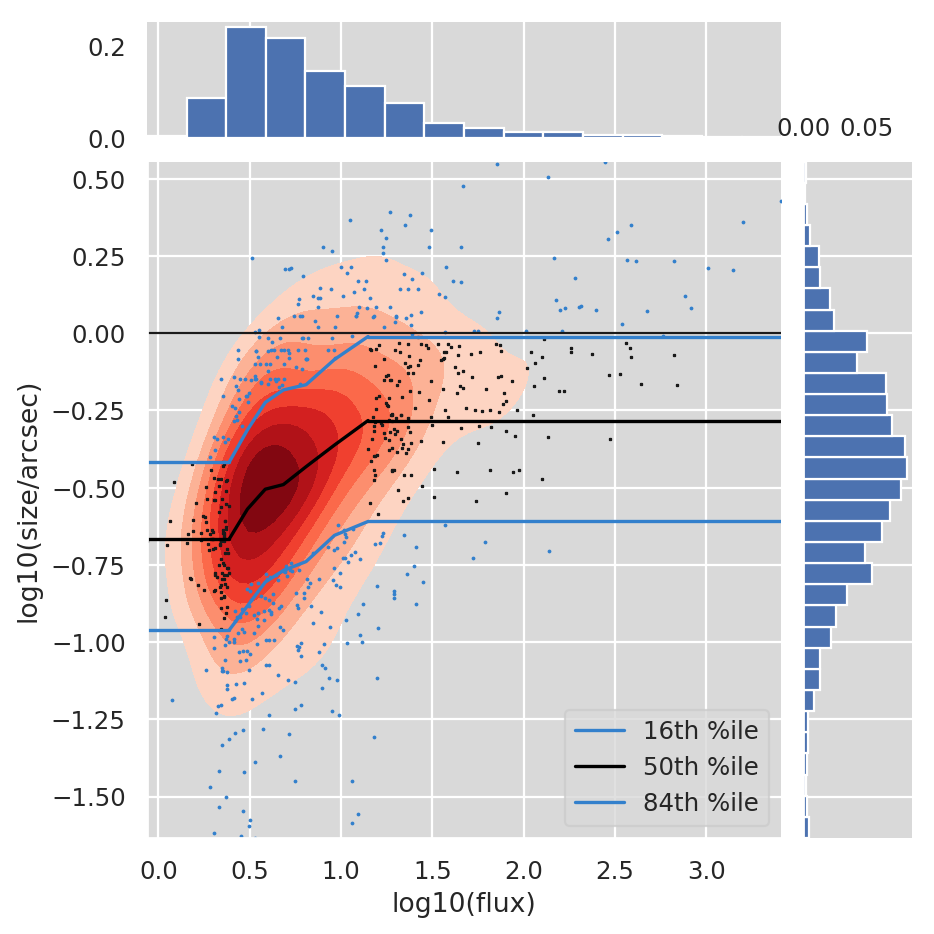

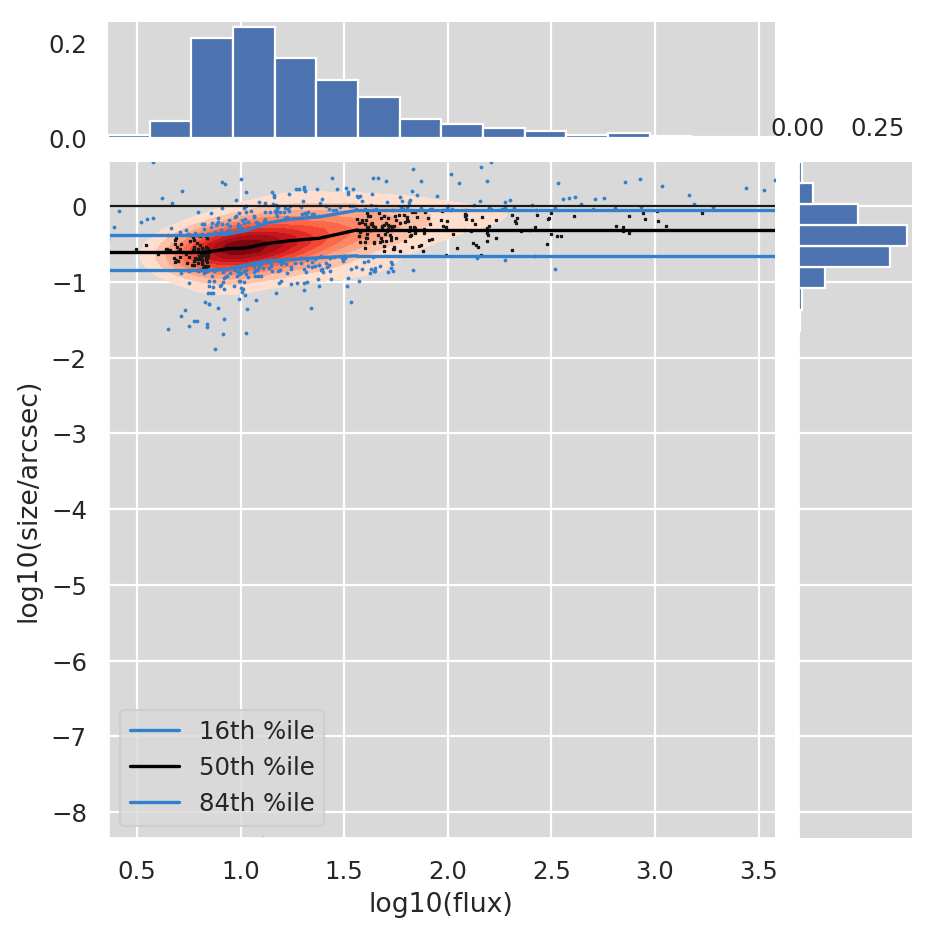

In [4]:
from modelling_research.plotting import plotjoint_running_percentiles
argspj = dict(
    percentiles = [16, 50, 84],
    percentilecolours = [(0.2, 0.5, 0.8), (0., 0., 0.), (0.2, 0.5, 0.8)],
    labelx='log10(flux)',
    labely='log10(size/arcsec)',
    scatterleft=True,
    scatterright=True,
)
for src in ['hst', 'hst2hsc']:
    x = np.log10(tab['profit.' + src + '.serbpx.flux.1'])
    y = np.log10(tab['profit.' + src + '.serbpx.re.1.1'])
    isfinite = np.isfinite(x) * np.isfinite(y)
    print('{} not finite out of {} for src={}'.format(len(x)-np.sum(isfinite), len(x), src))
    plotjoint_running_percentiles(x[isfinite], y[isfinite], ndivisions=8, nbinspan=1, **argspj)

### Size-flux relations compared between different Sersic models

Are there correlations between the sizes/fluxes of Gaussian/exponential/n=2/de Vaucouleurs profiles? If so, they could be used to improve model initialization.

/software/lsstsw/stack_20190330/python/miniconda3-4.5.12/envs/lsst-scipipe/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


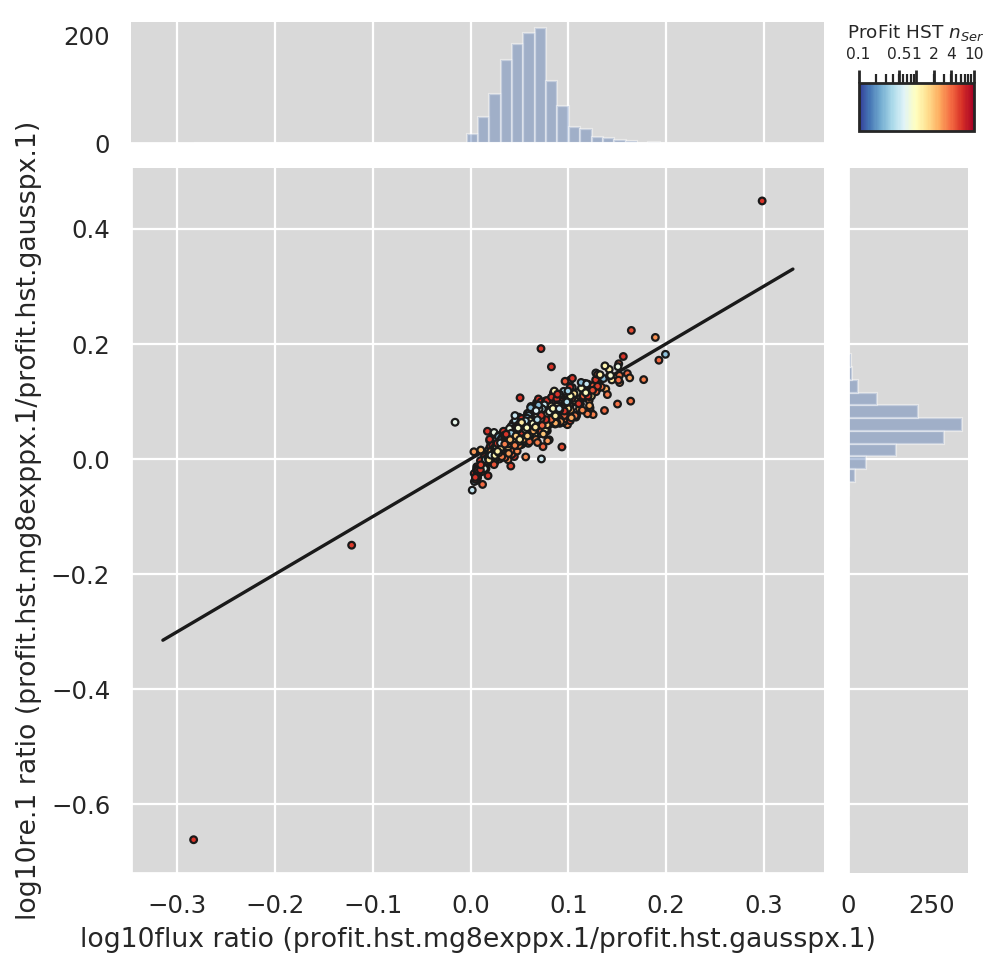

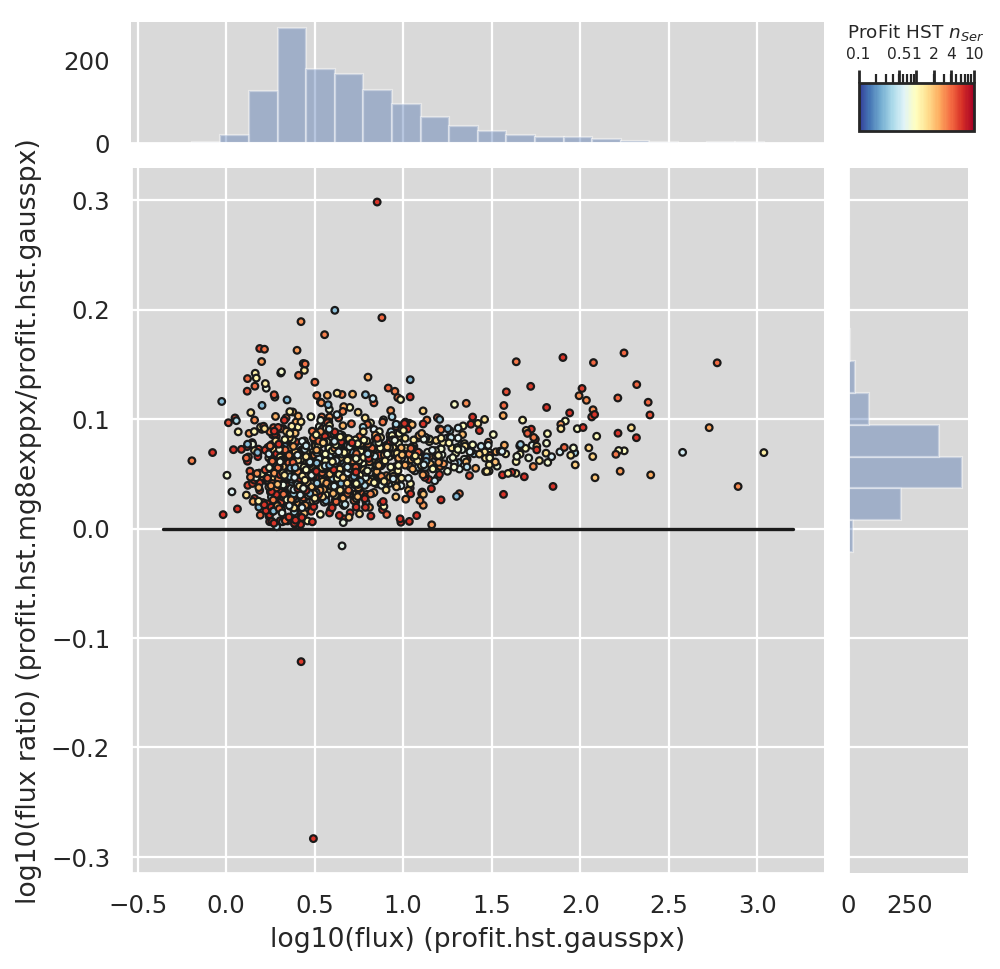

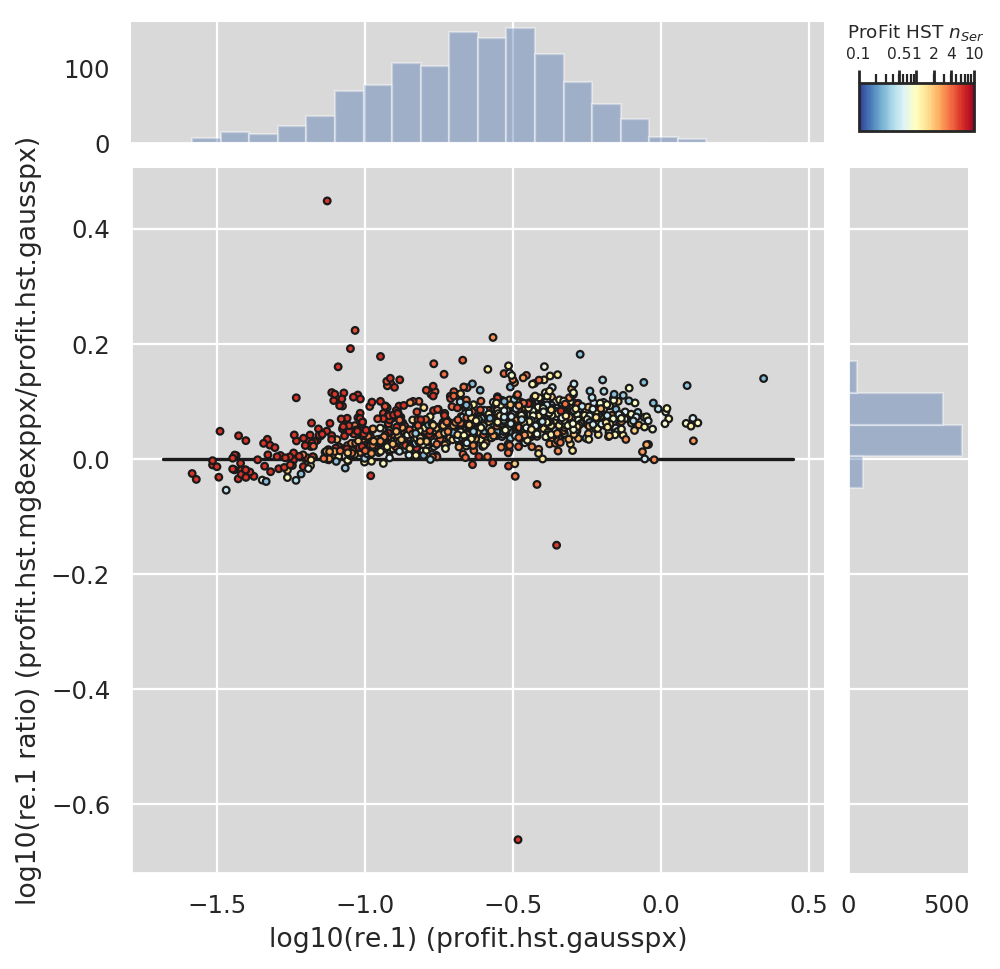

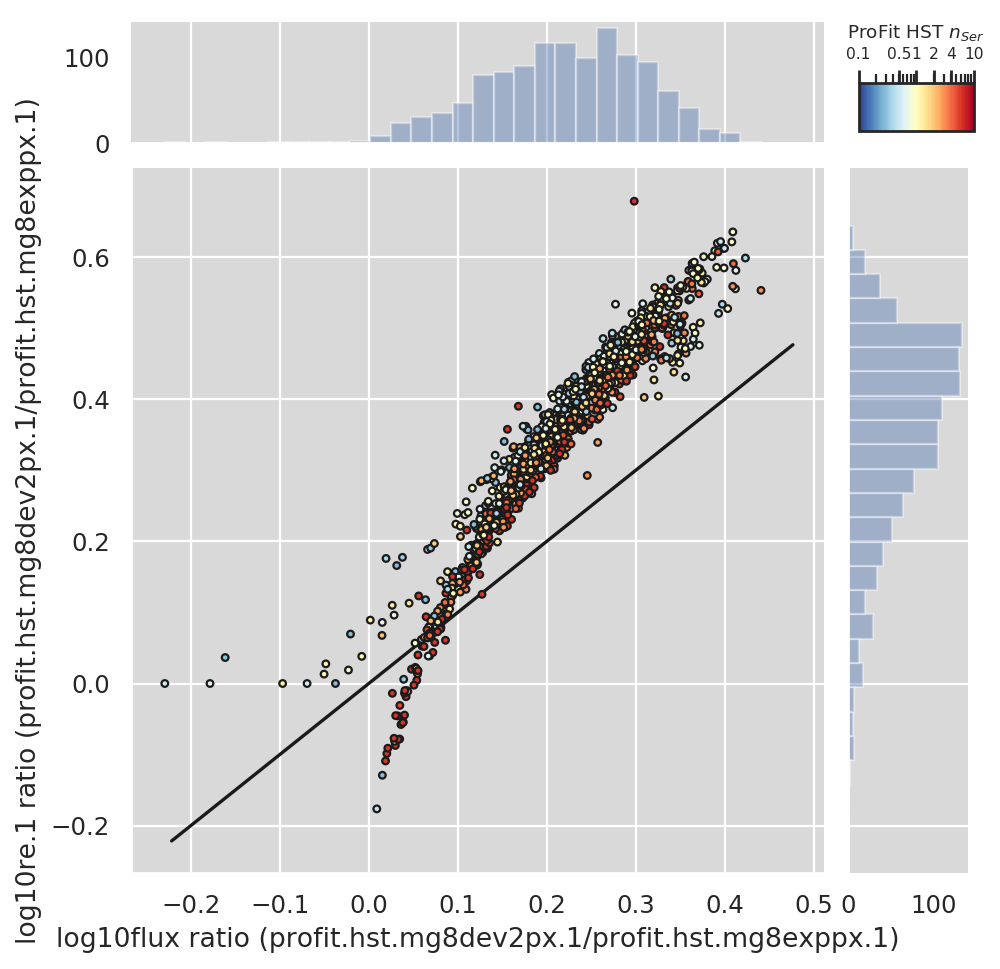

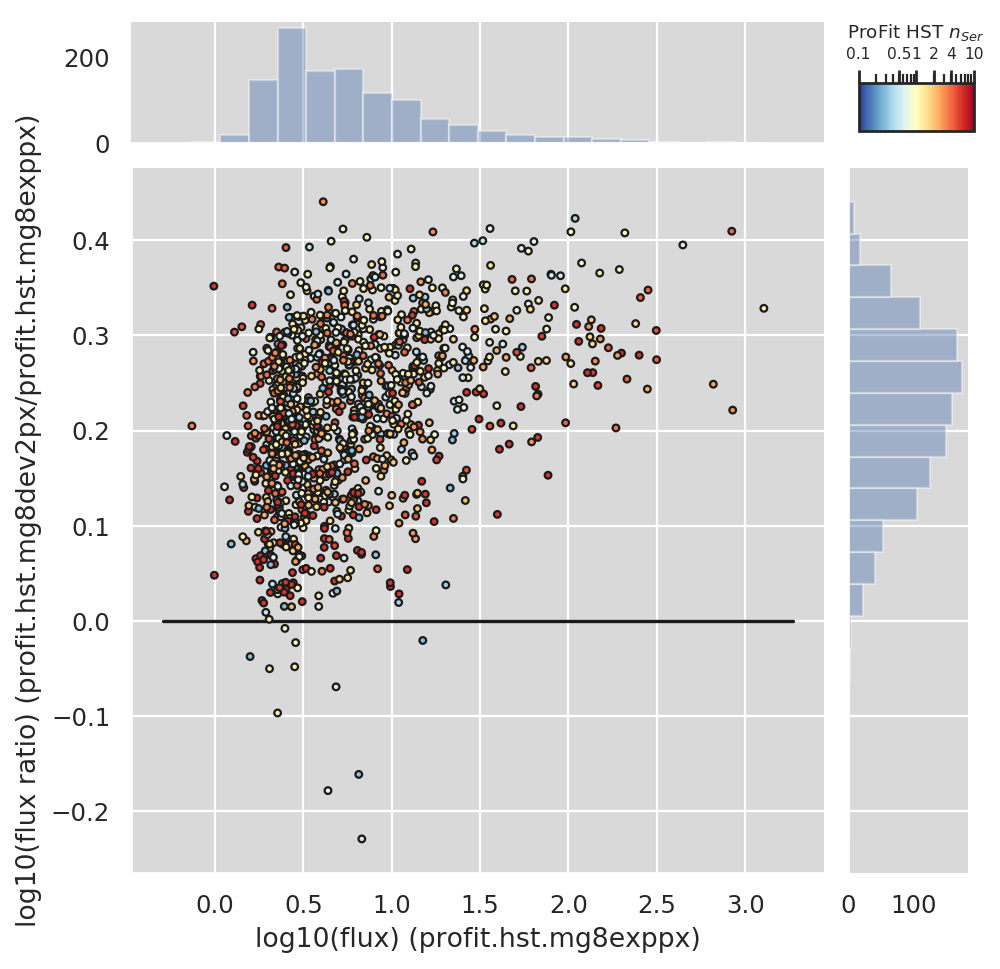

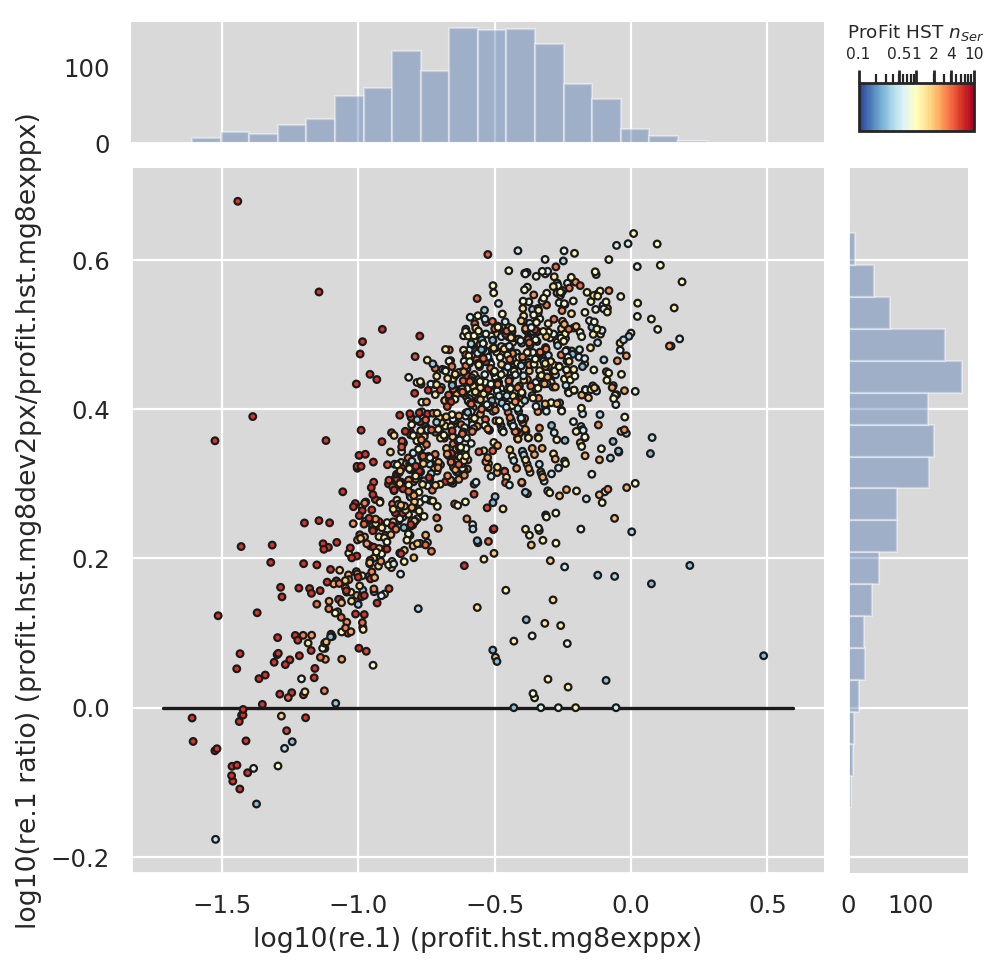

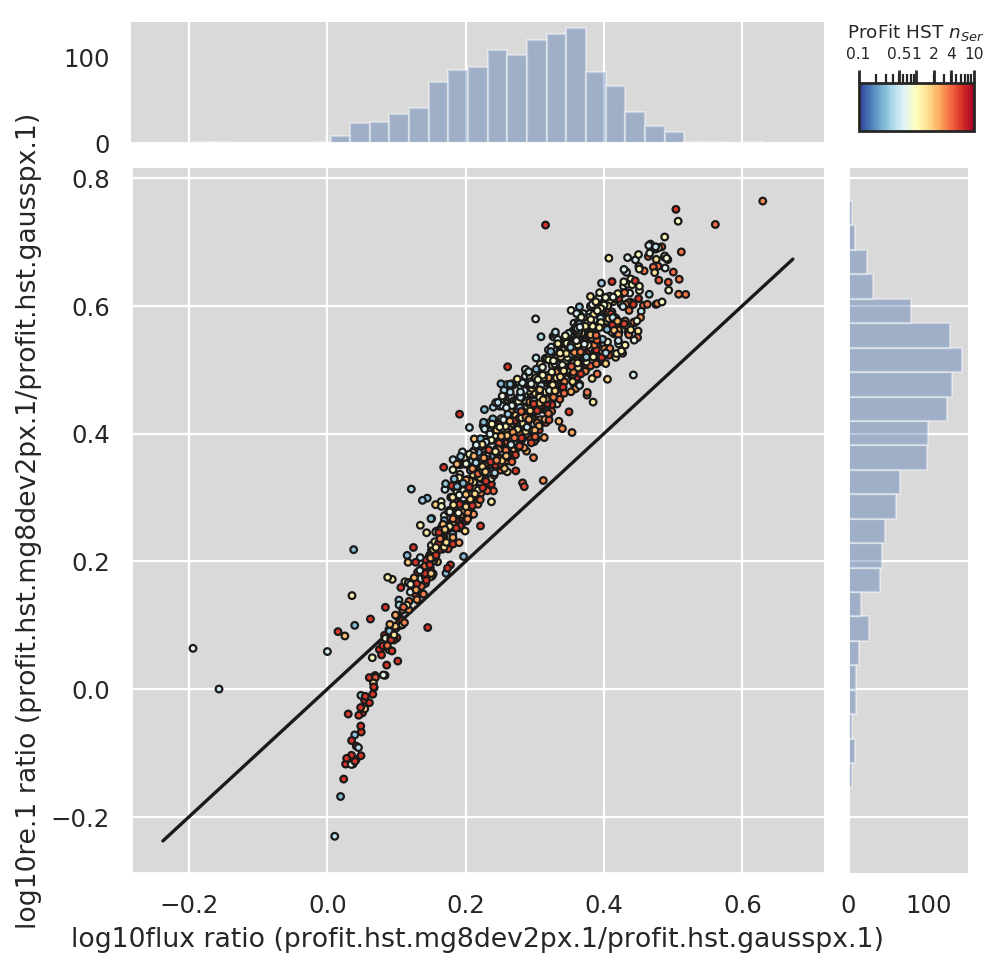

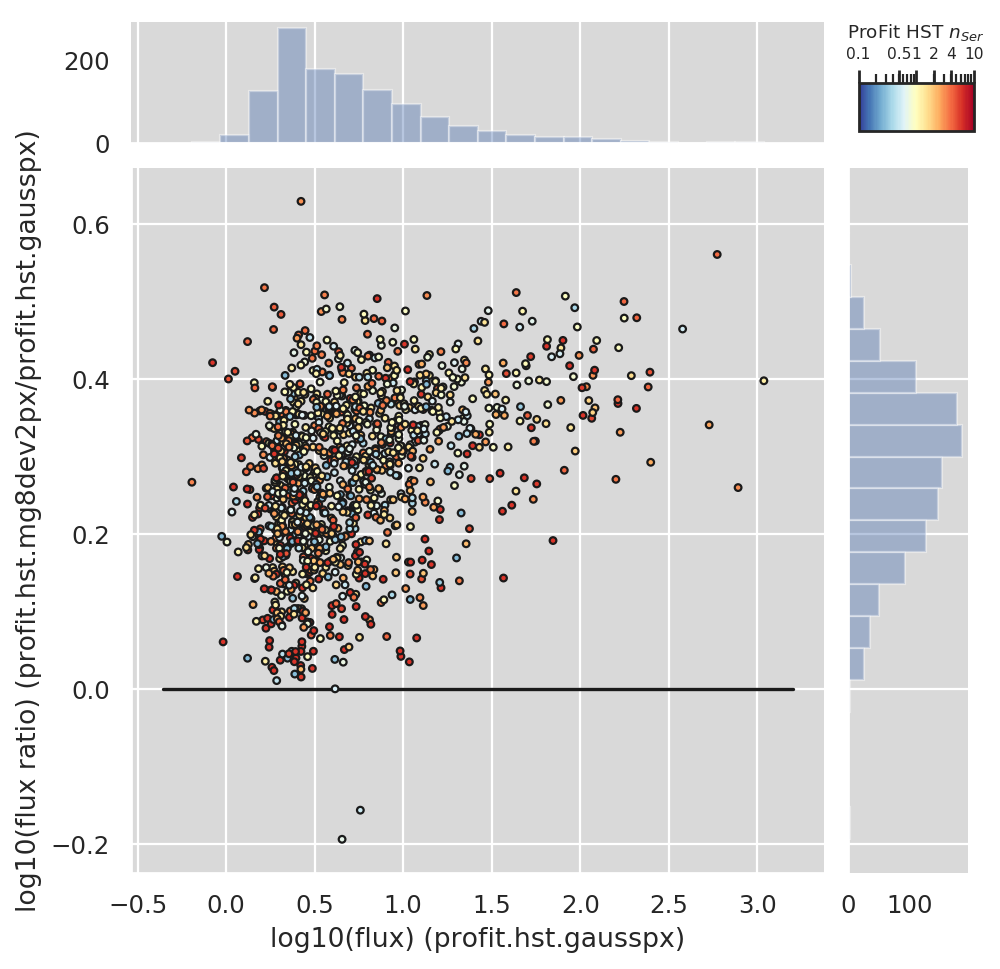

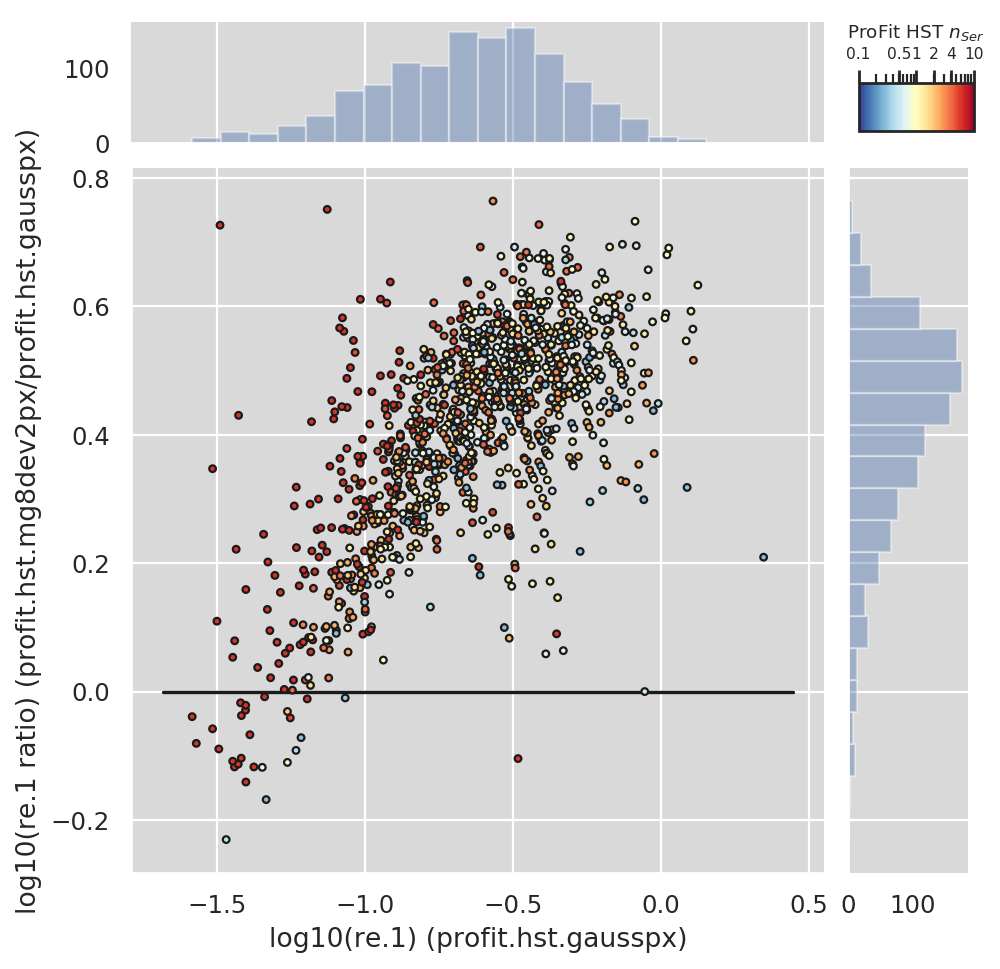

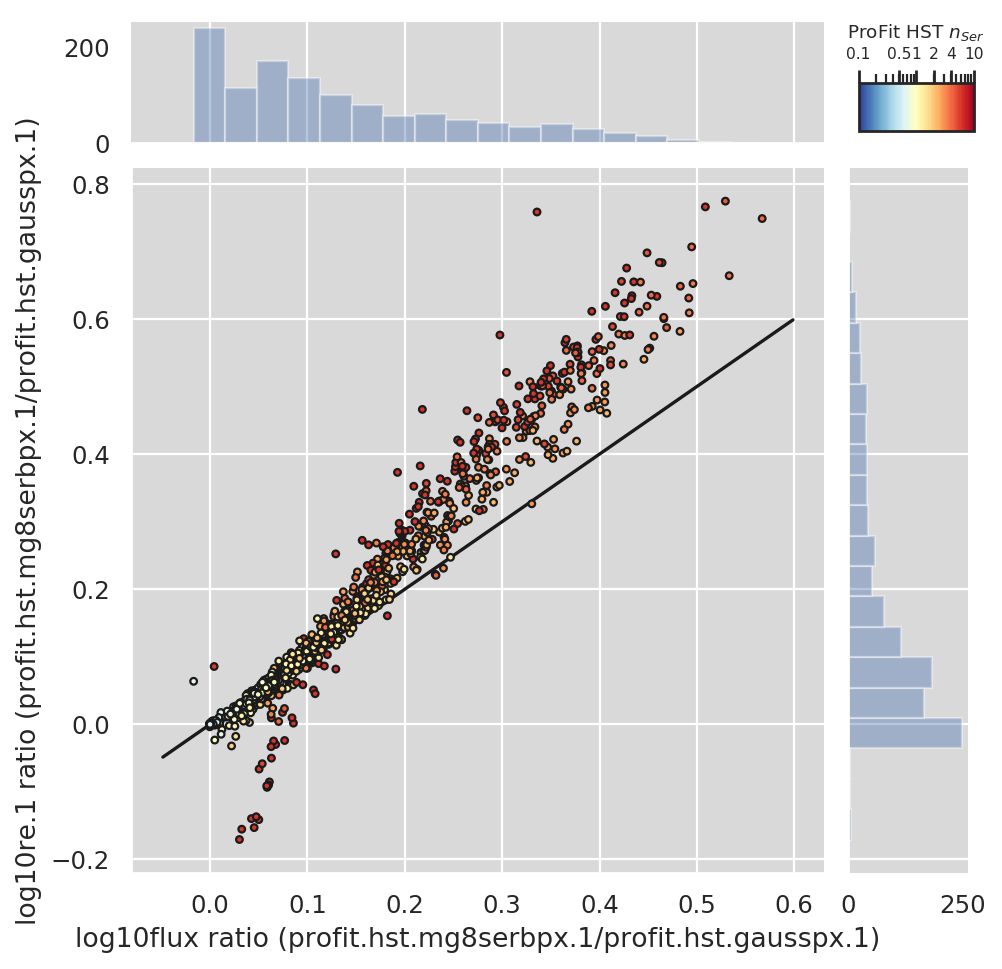

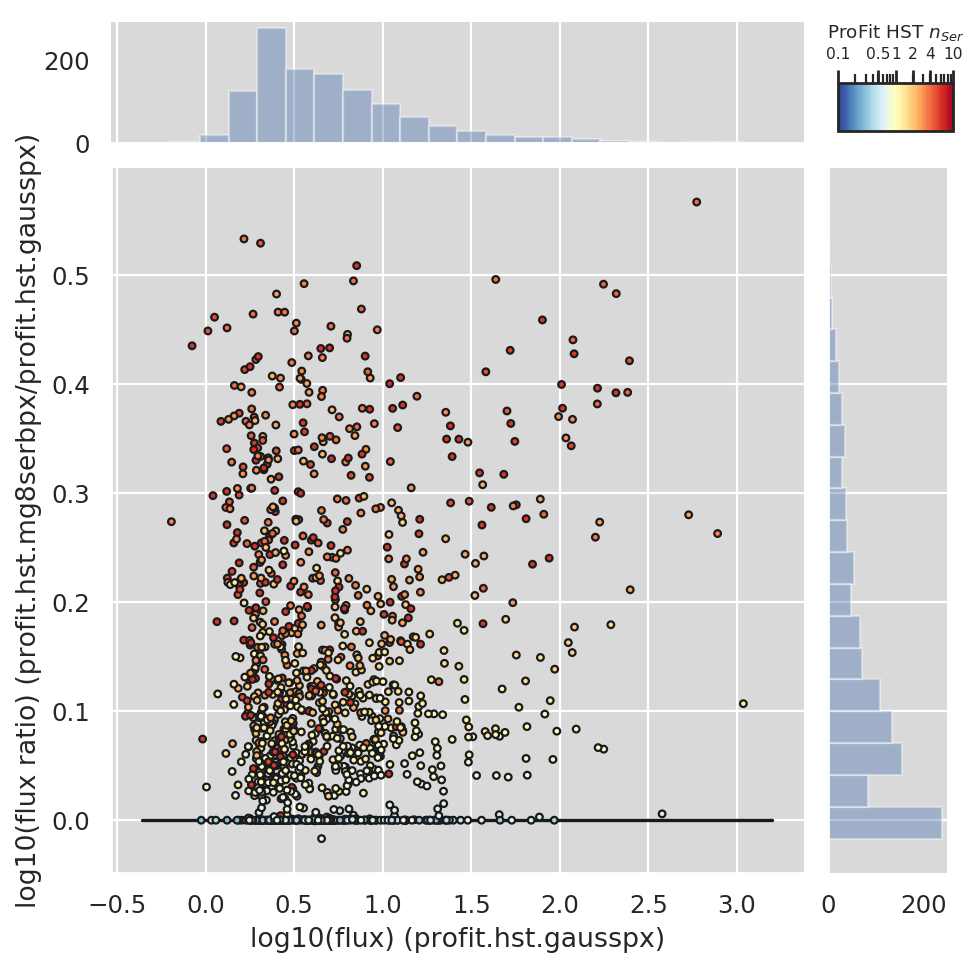

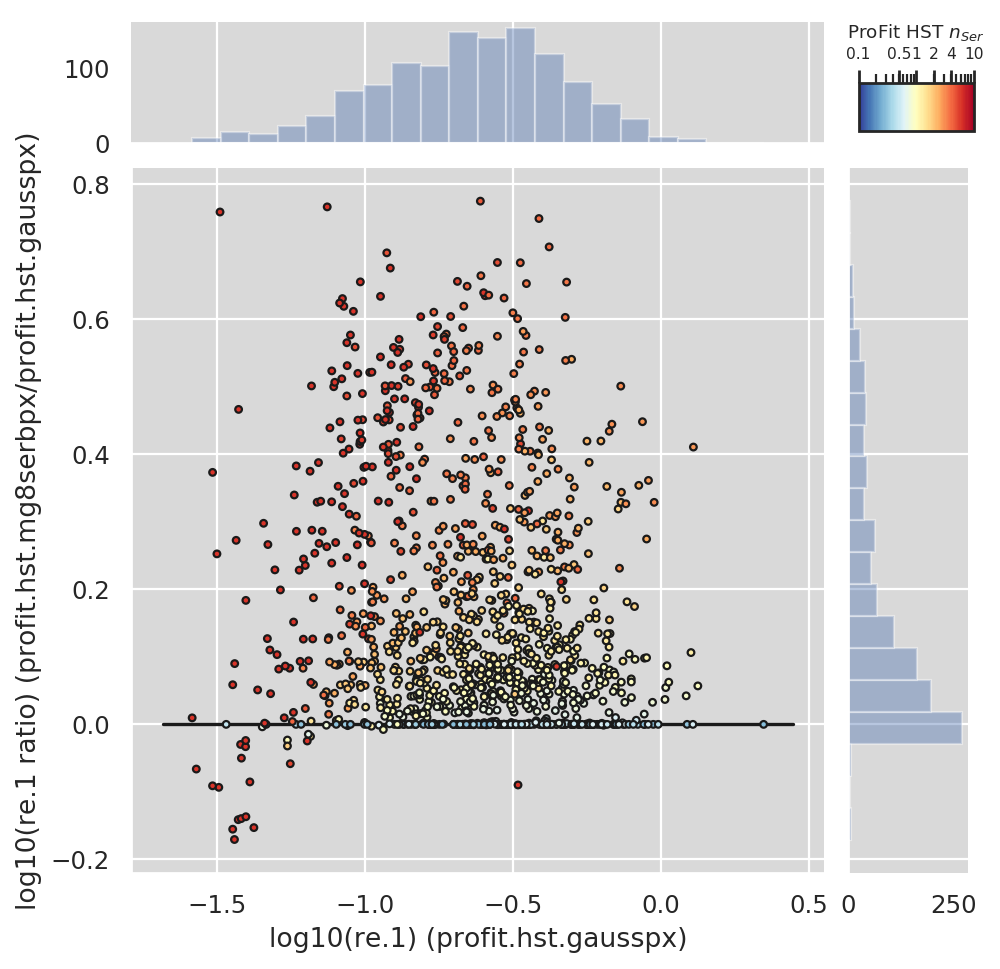

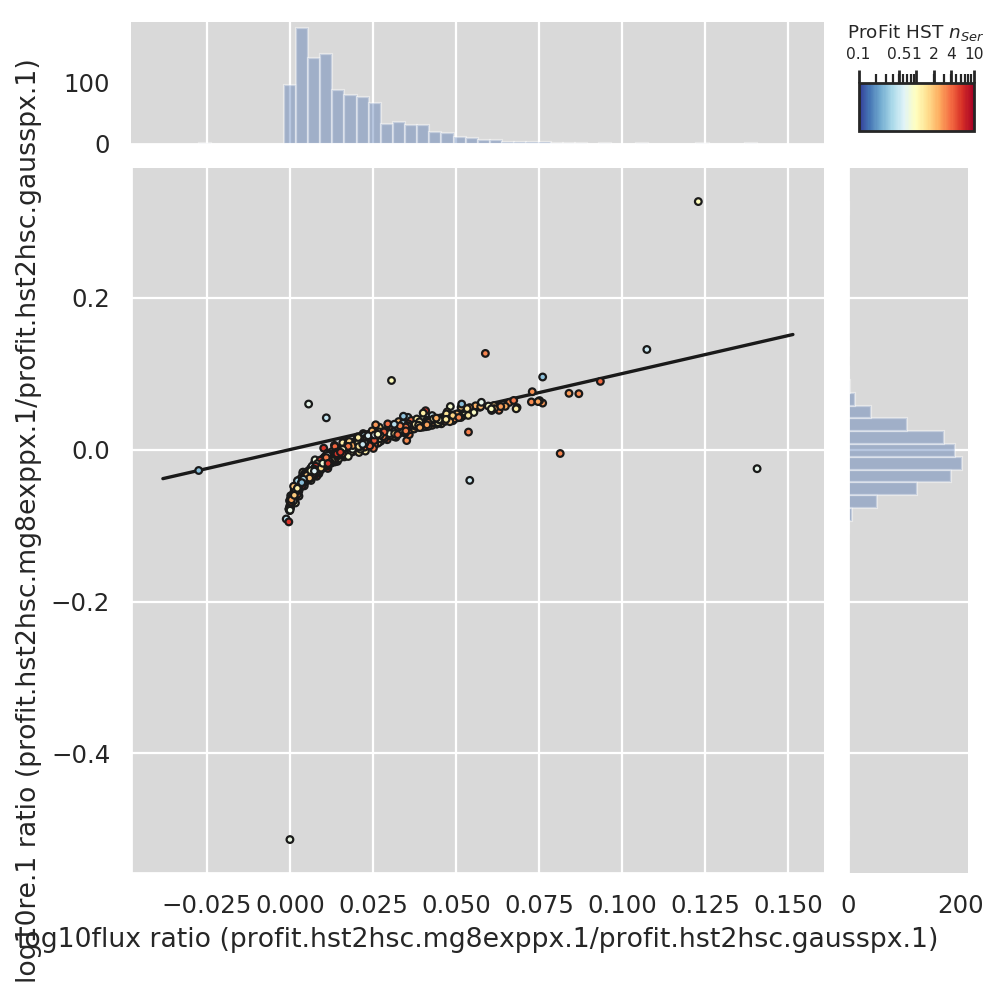

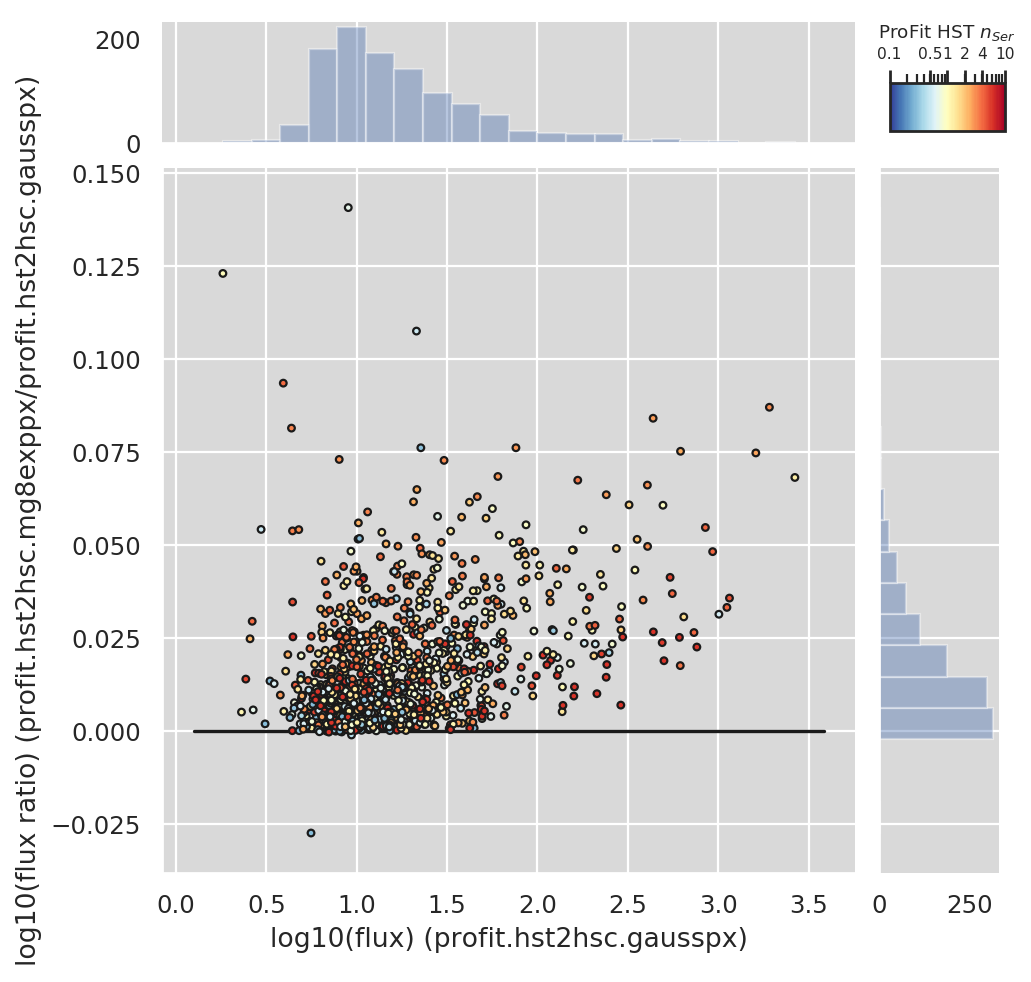

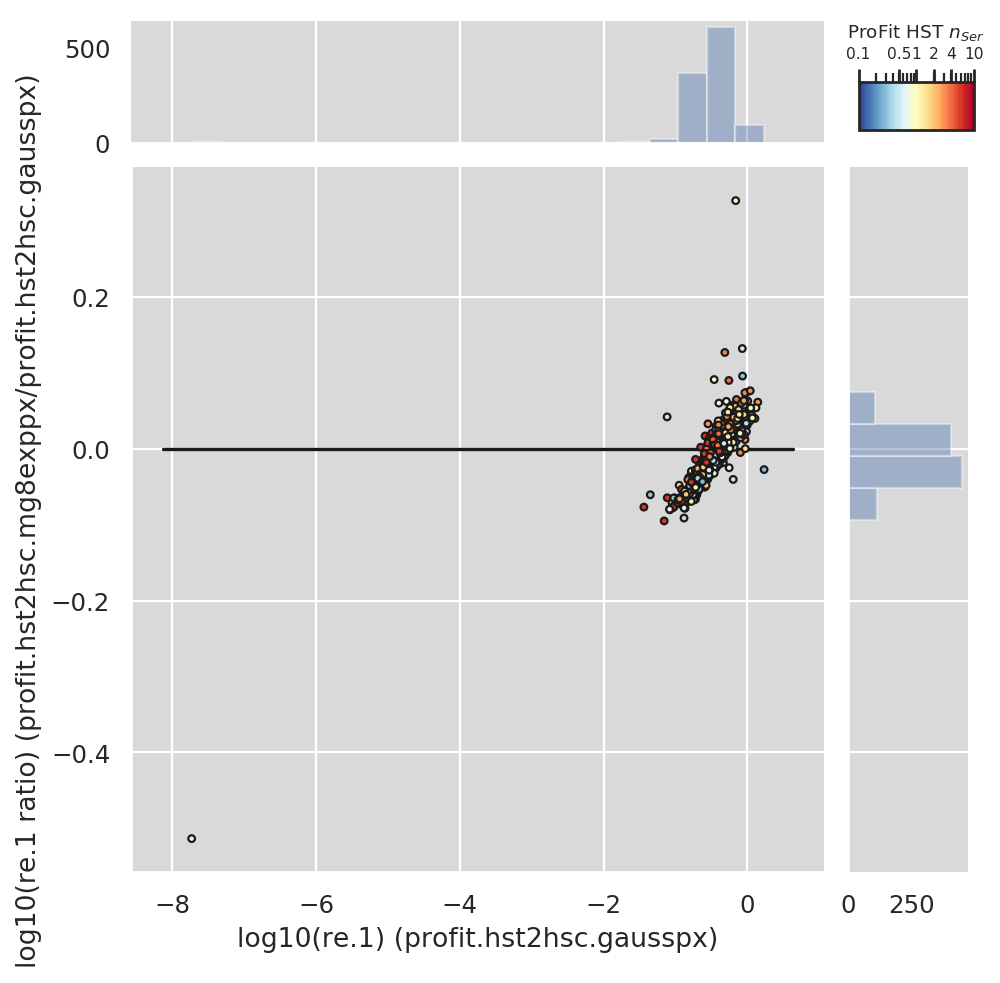

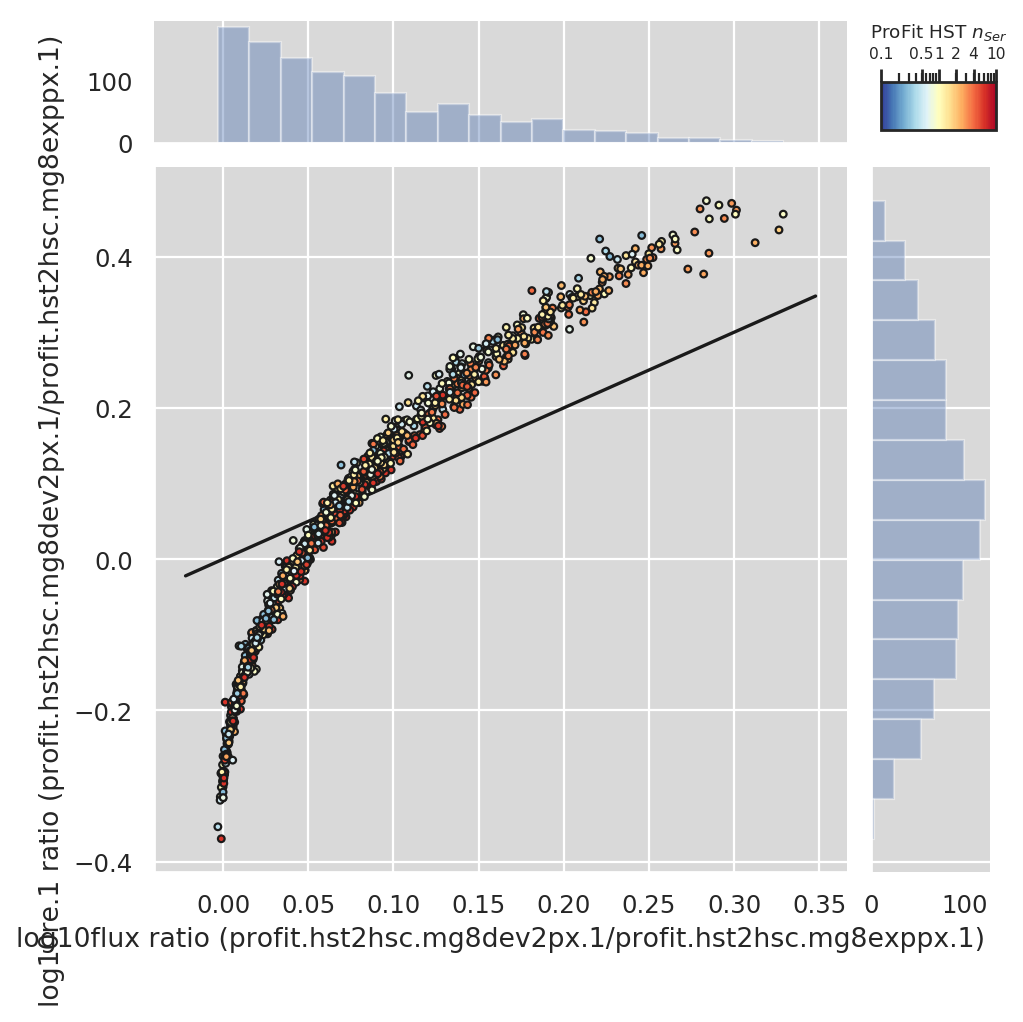

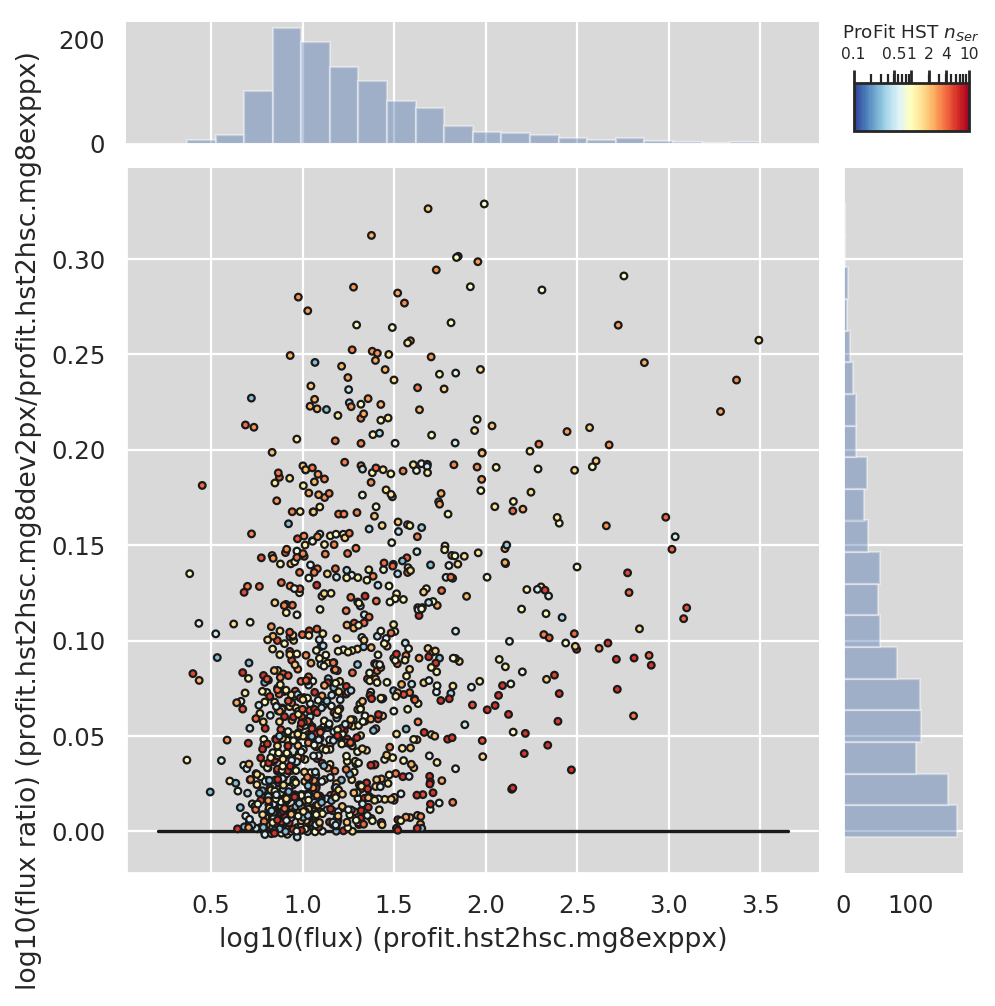

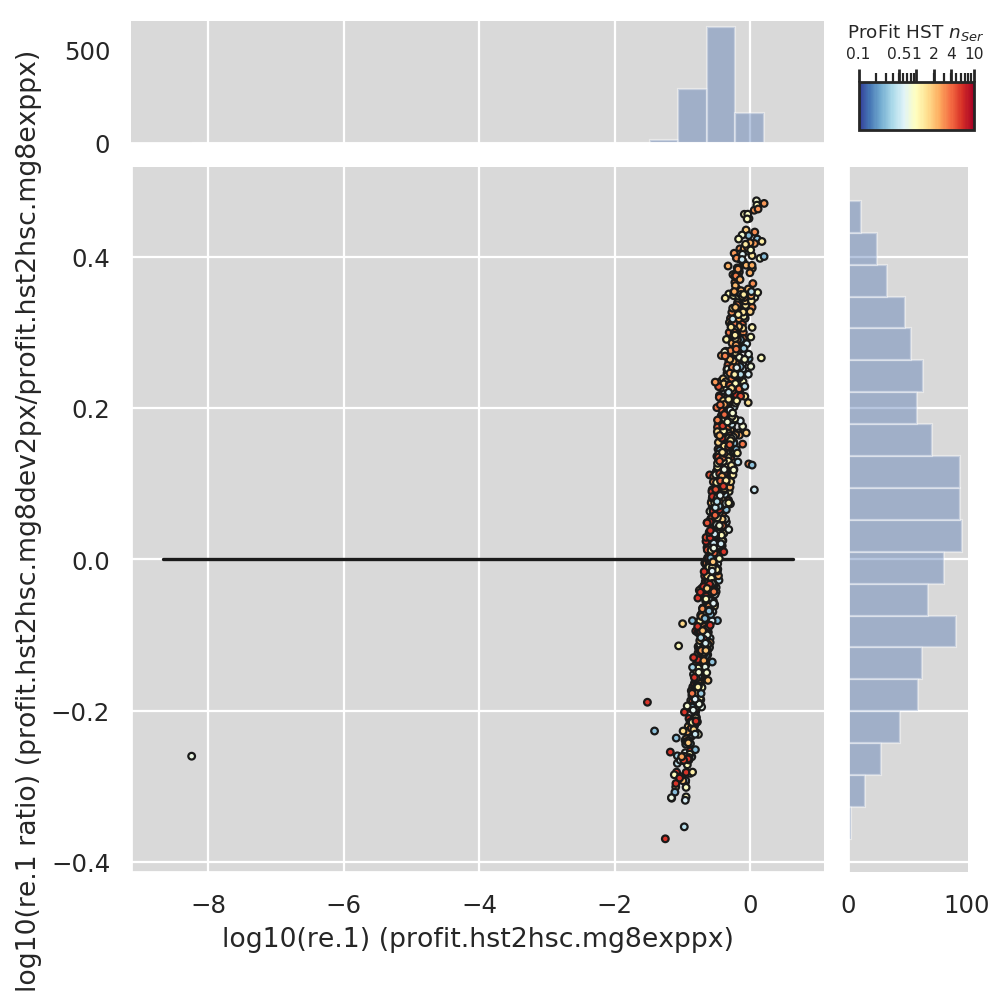

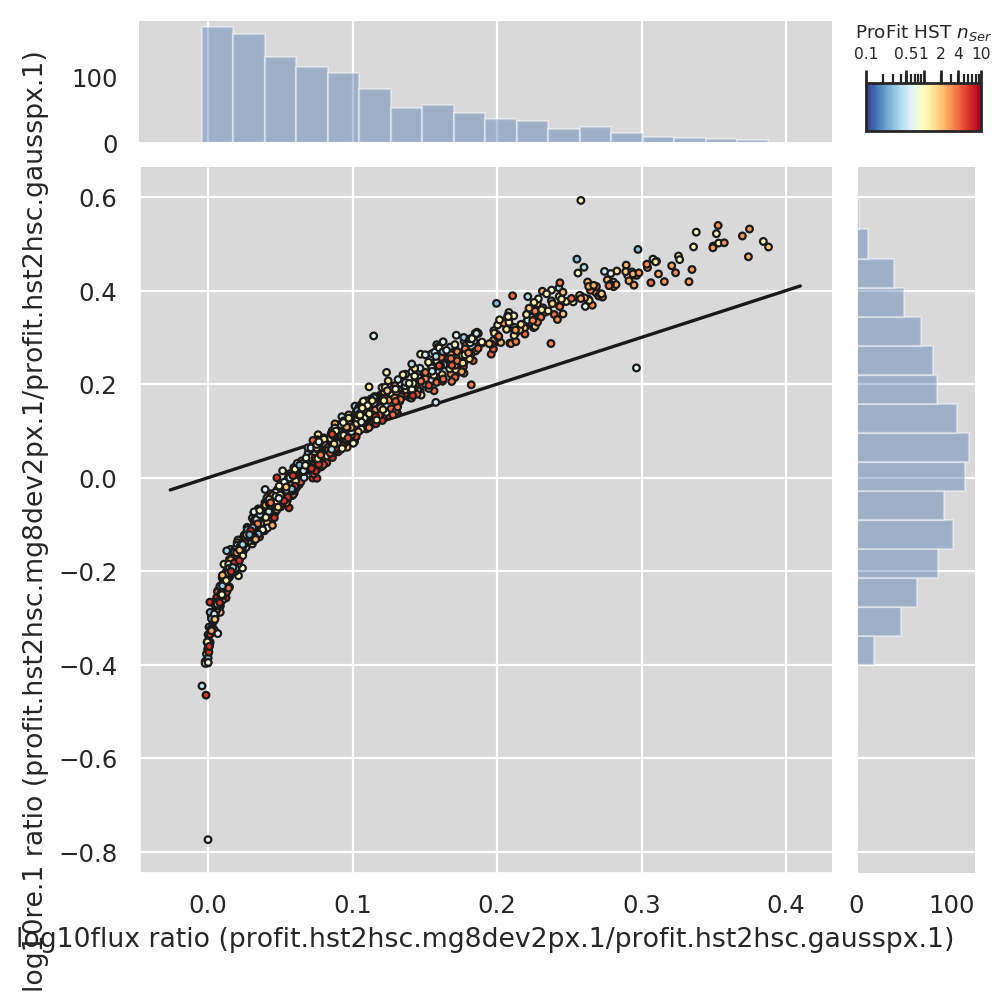

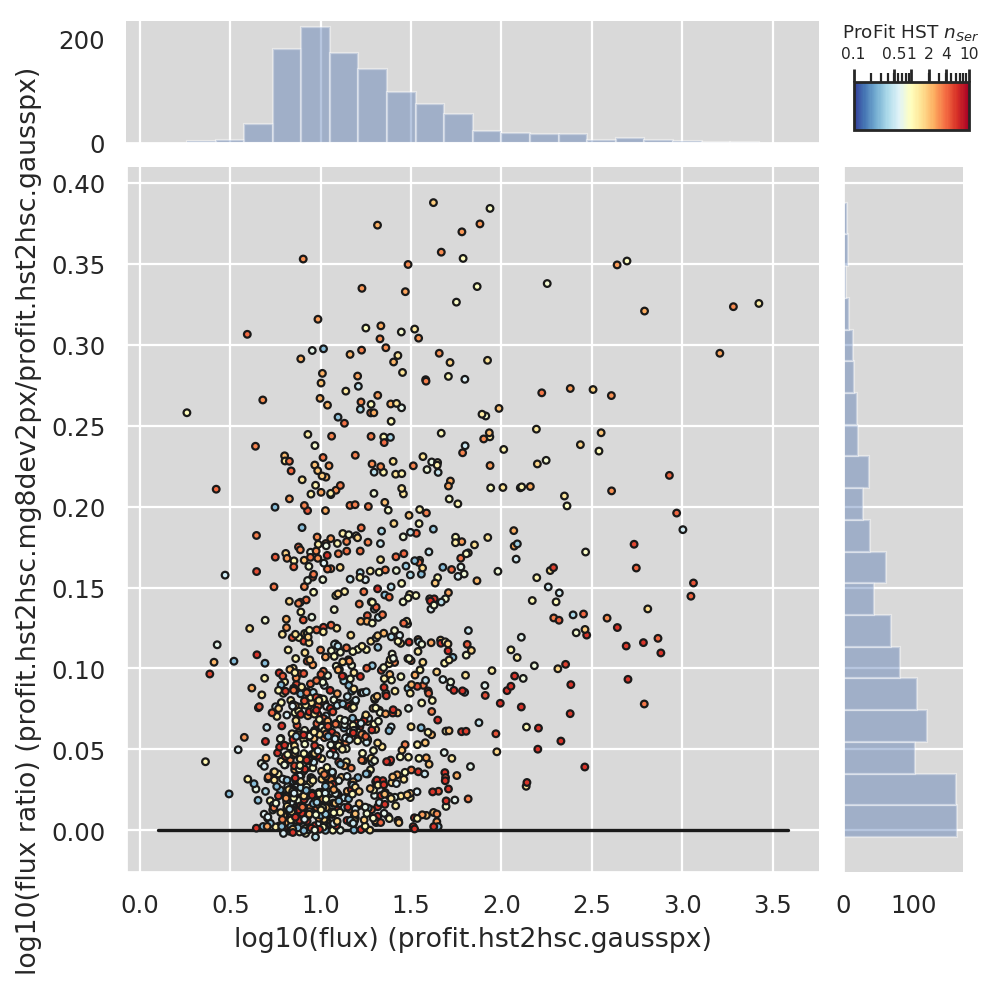

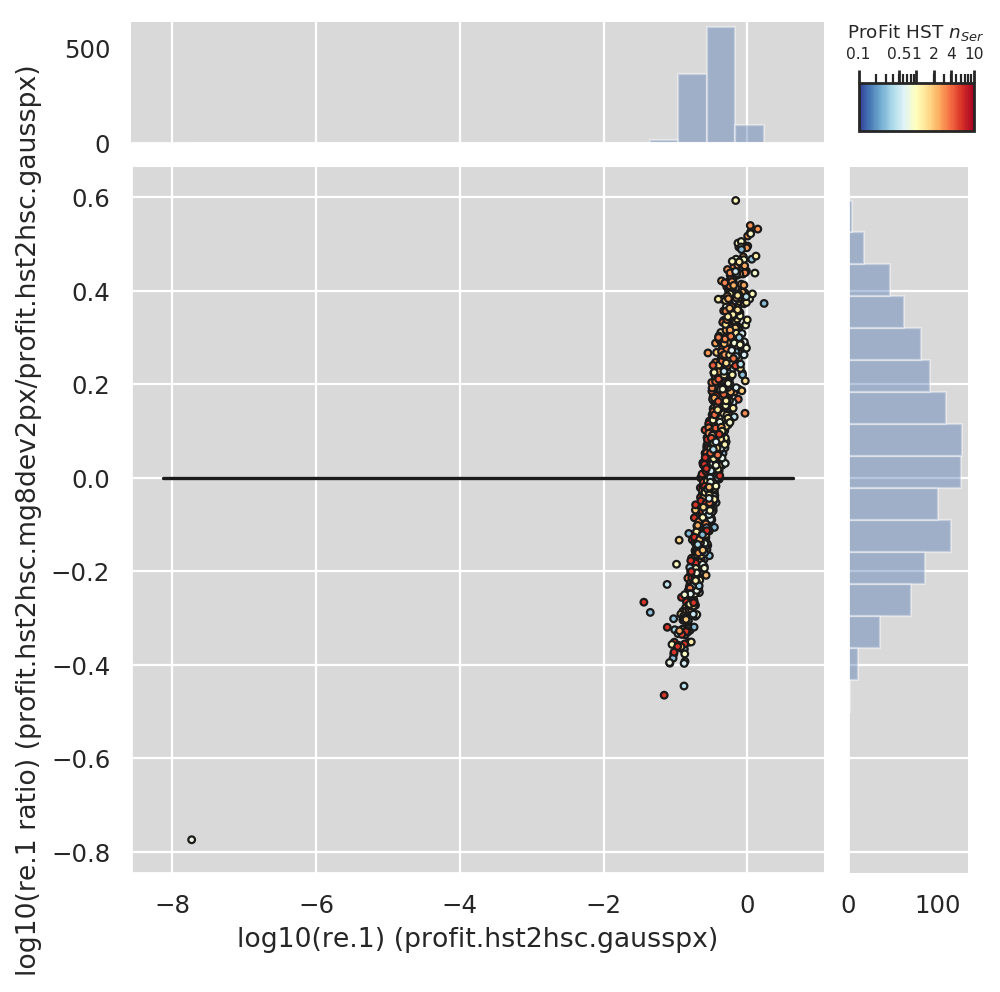

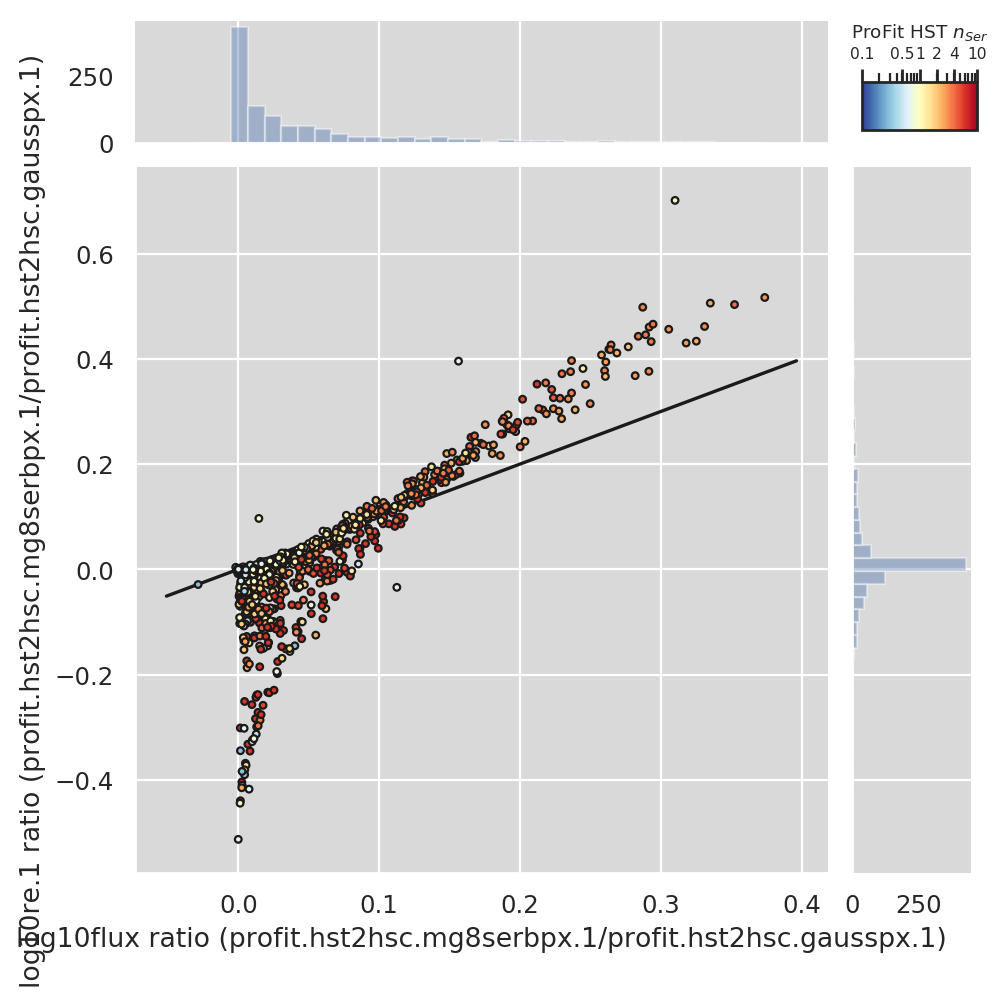

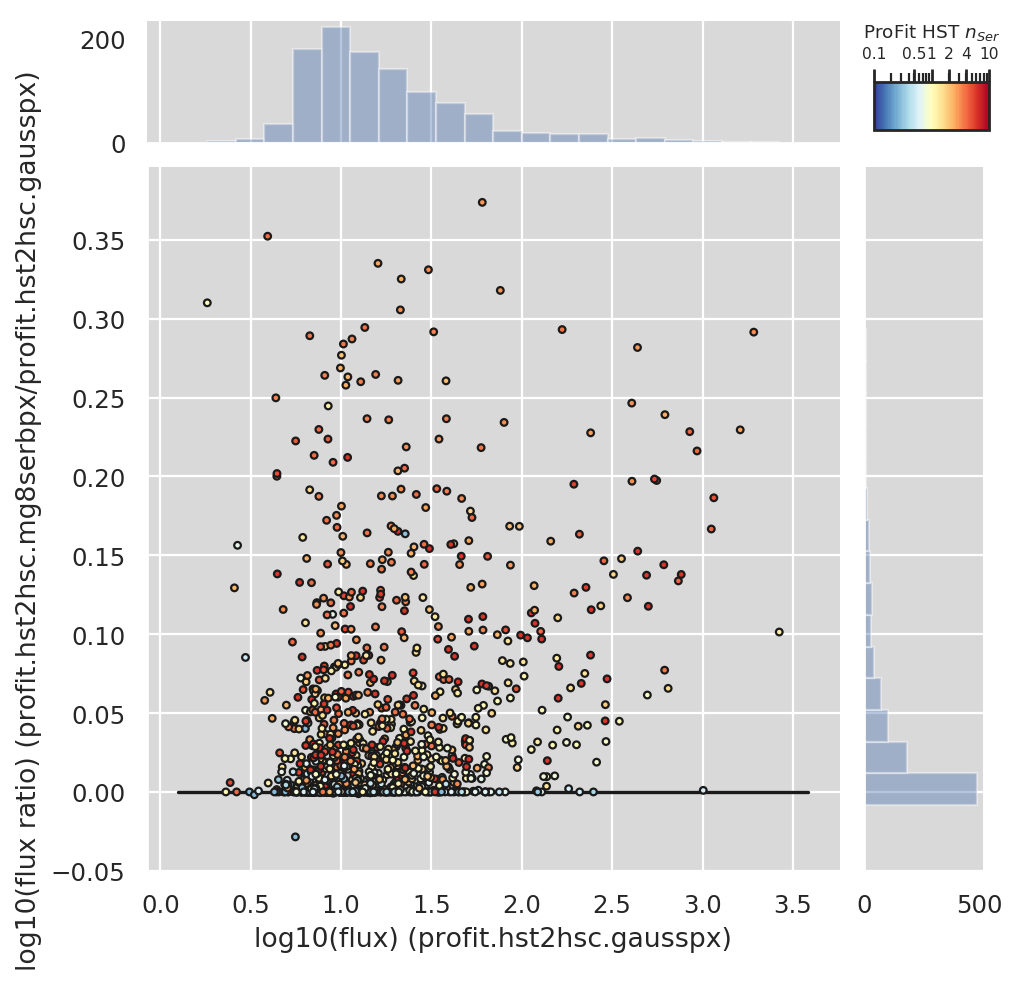

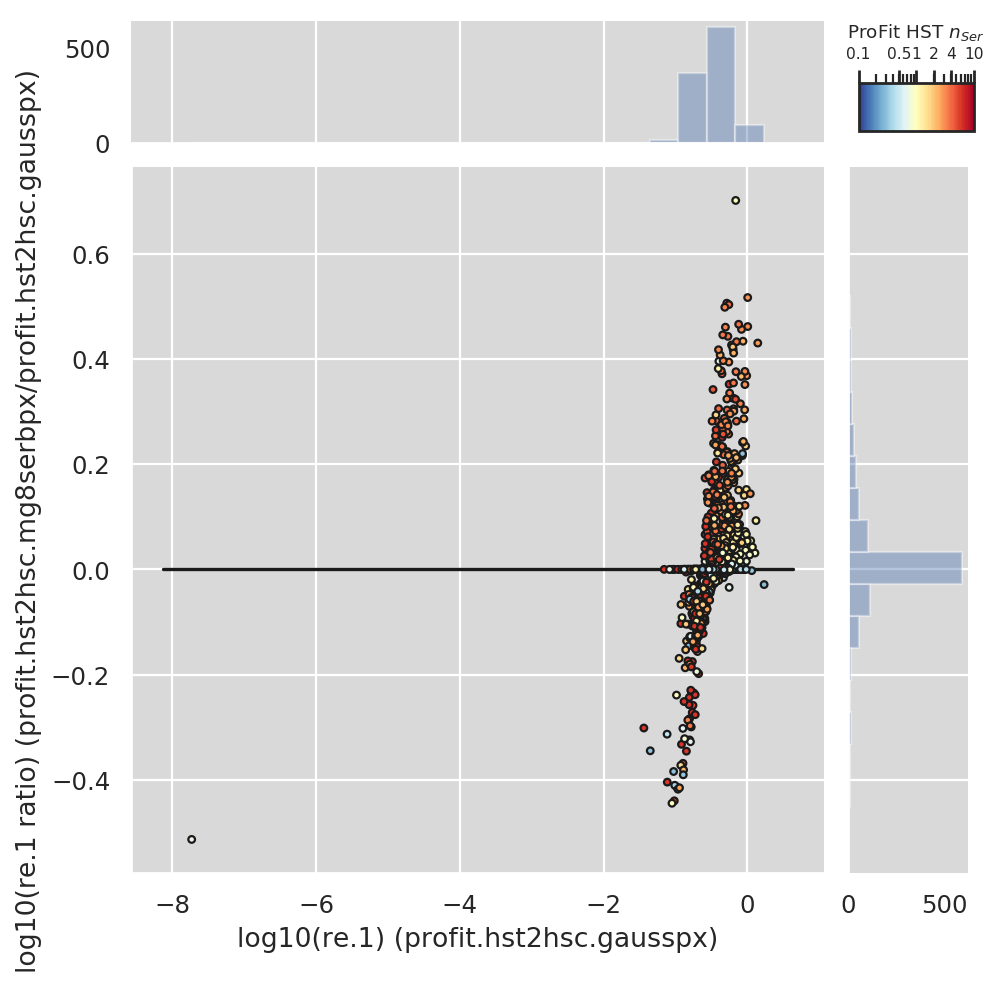

In [5]:
from modelling_research.plot_multiprofit_cosmos import plotjointsersic
varnames = ["flux", "re.1"]
for src in ['hst', 'hst2hsc']:
    plots = plotjointsersic(tab, 'profit.' + src + '.gausspx', 'profit.' + src + '.mg8exppx', varnames, plotratiosjoint=True, postfixx='1', postfixy='1')
    
    plotjointsersic(tab, 'profit.' + src + '.mg8exppx', 'profit.' + src + '.mg8dev2px', varnames, plotratiosjoint=True, postfixx='1', postfixy='1')
    plotjointsersic(tab, 'profit.' + src + '.gausspx', 'profit.' + src + '.mg8dev2px', varnames, plotratiosjoint=True, postfixx='1', postfixy='1')
    plotjointsersic(tab, 'profit.' + src + '.gausspx', 'profit.' + src + '.mg8serbpx', varnames, plotratiosjoint=True, postfixx='1', postfixy='1')

/home/dtaranu/src/mine/modelling_research/plotting.py:136: RuntimeWarning: divide by zero encountered in log10
  y = np.log10(y, out=y)


([<seaborn.axisgrid.JointGrid at 0x7f0fc8d3fc18>,
 [])

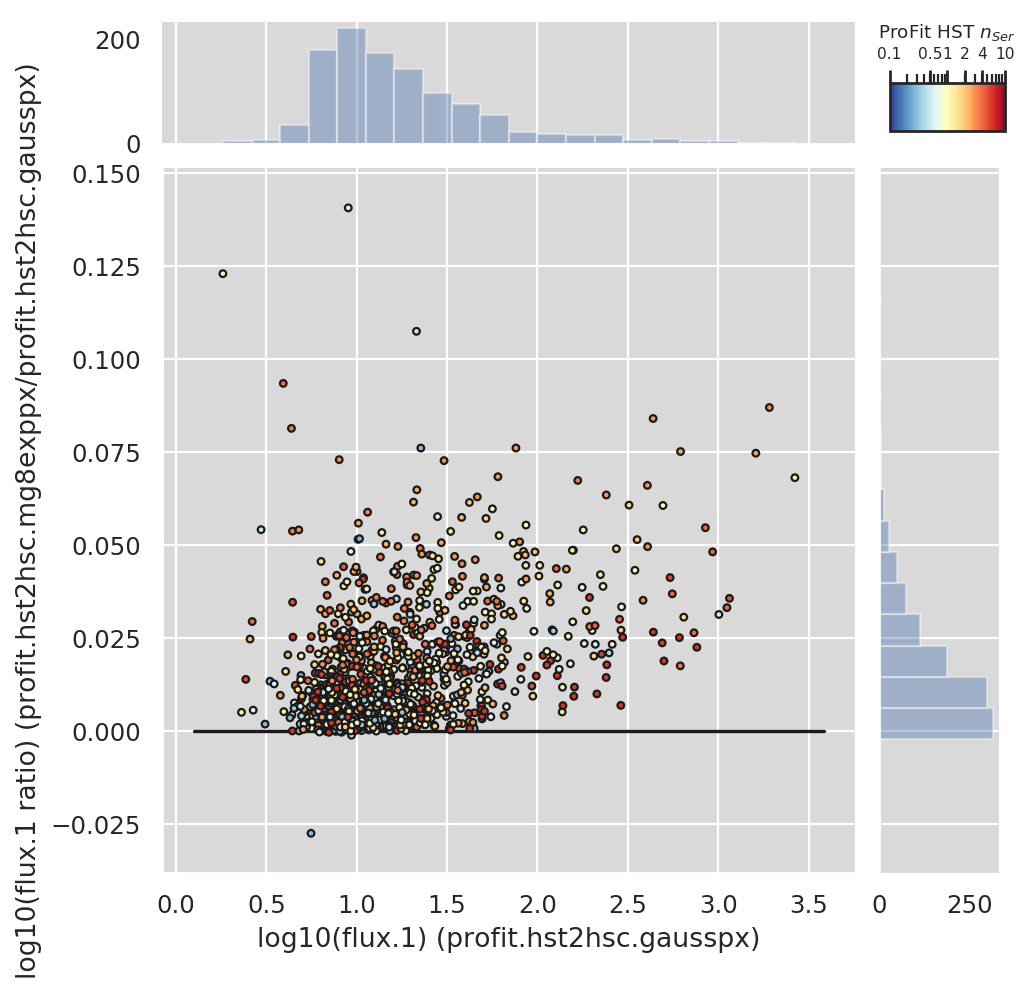

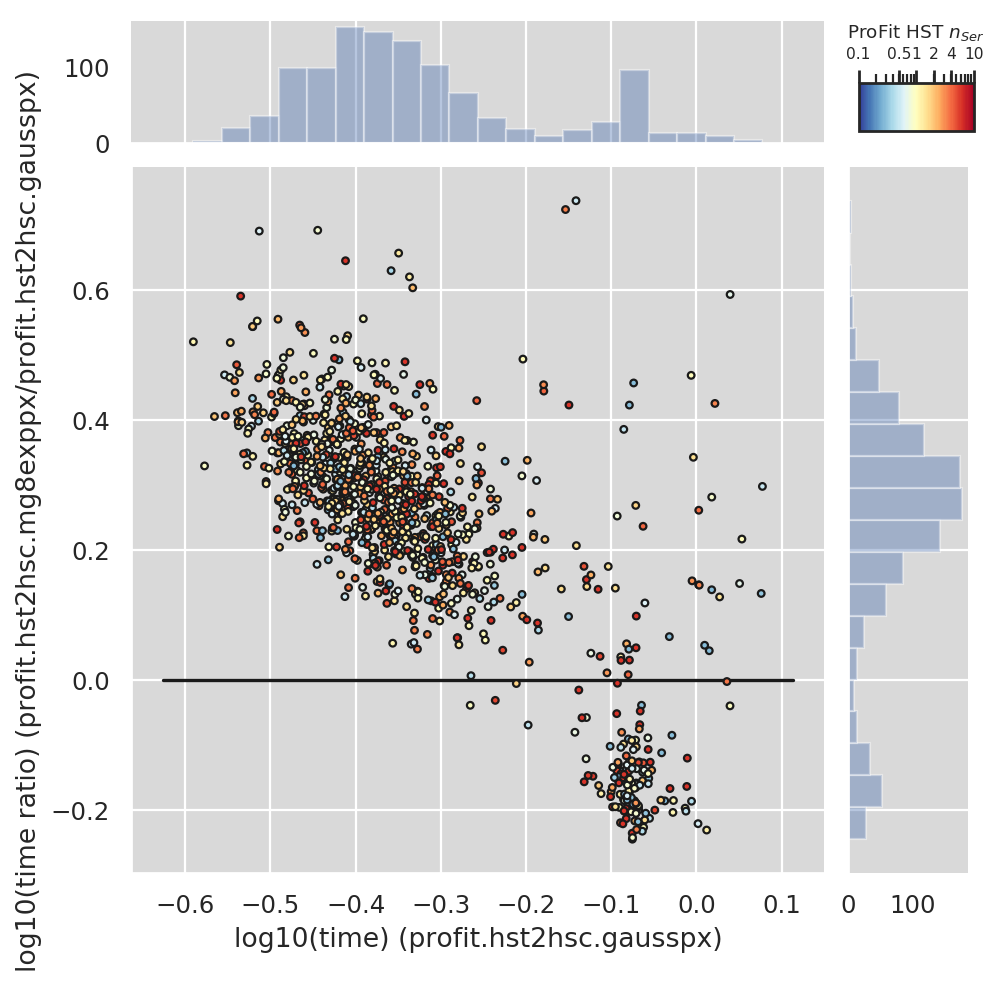

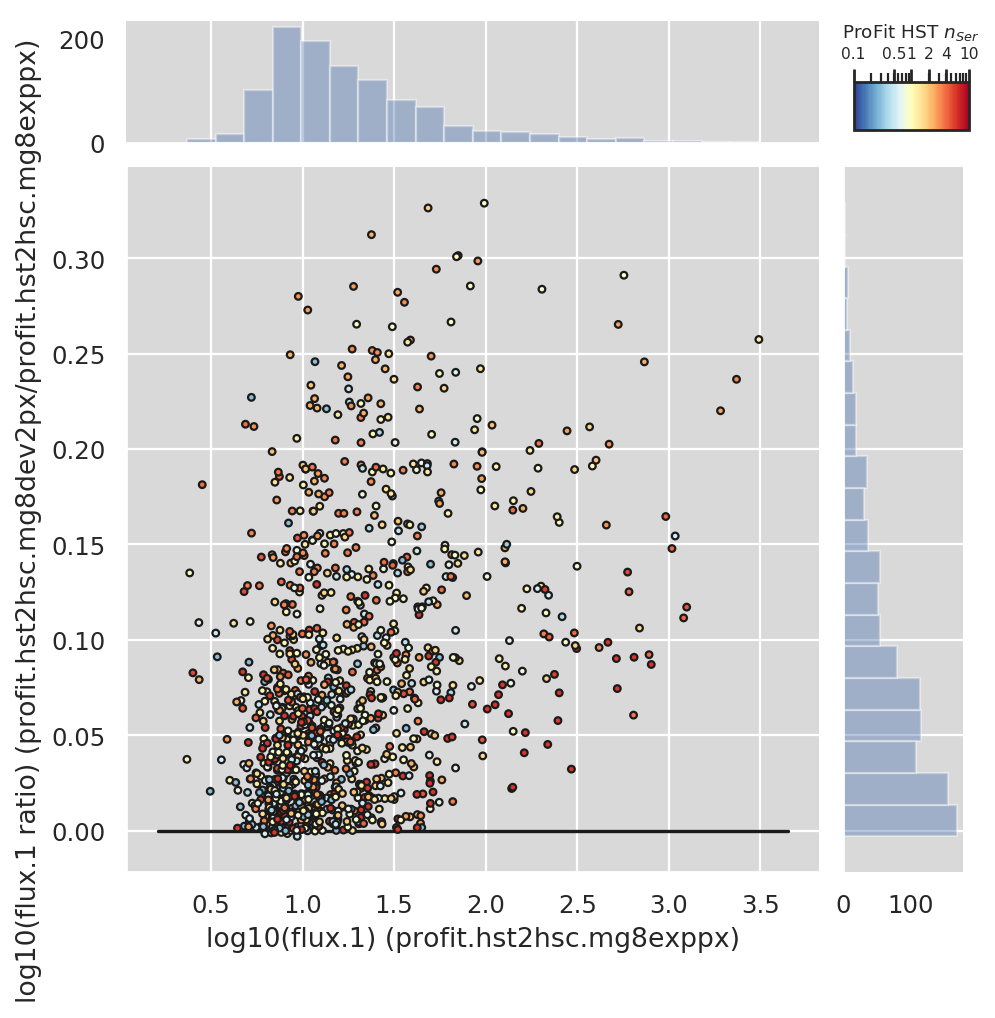

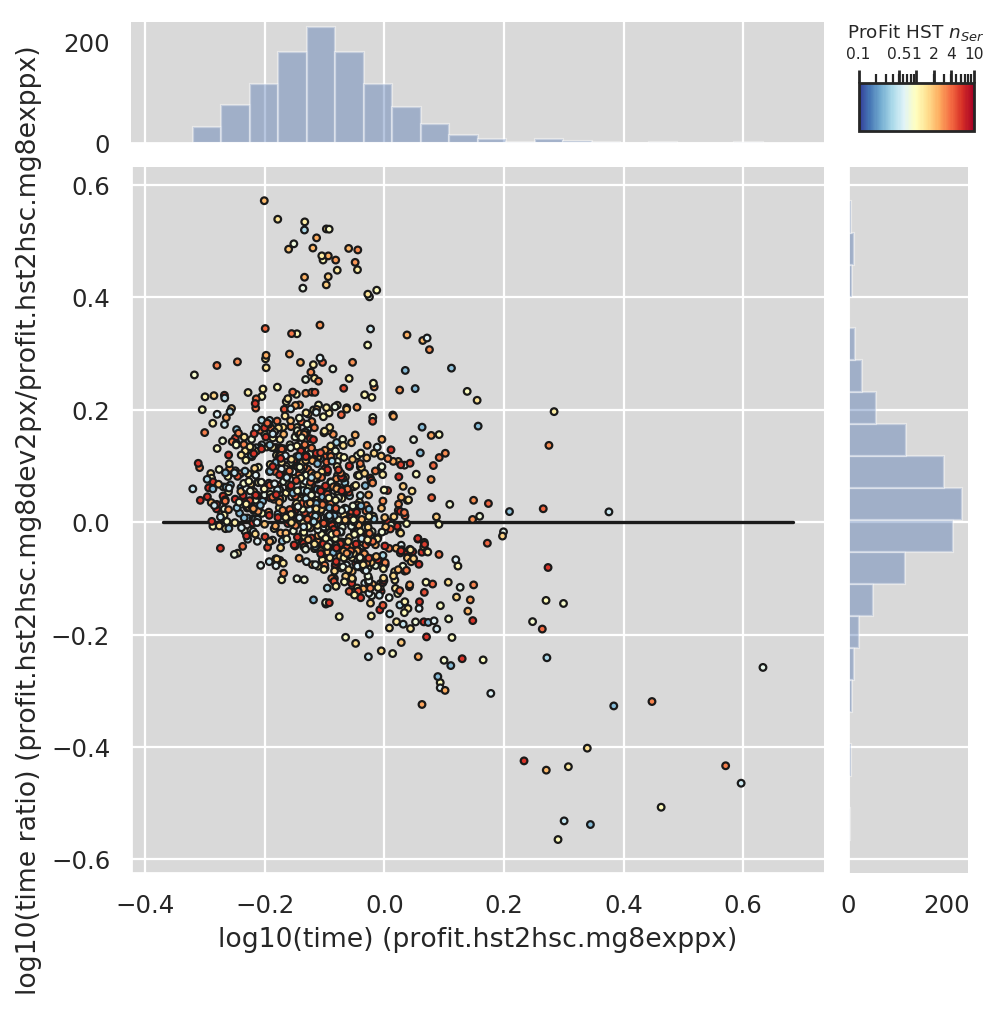

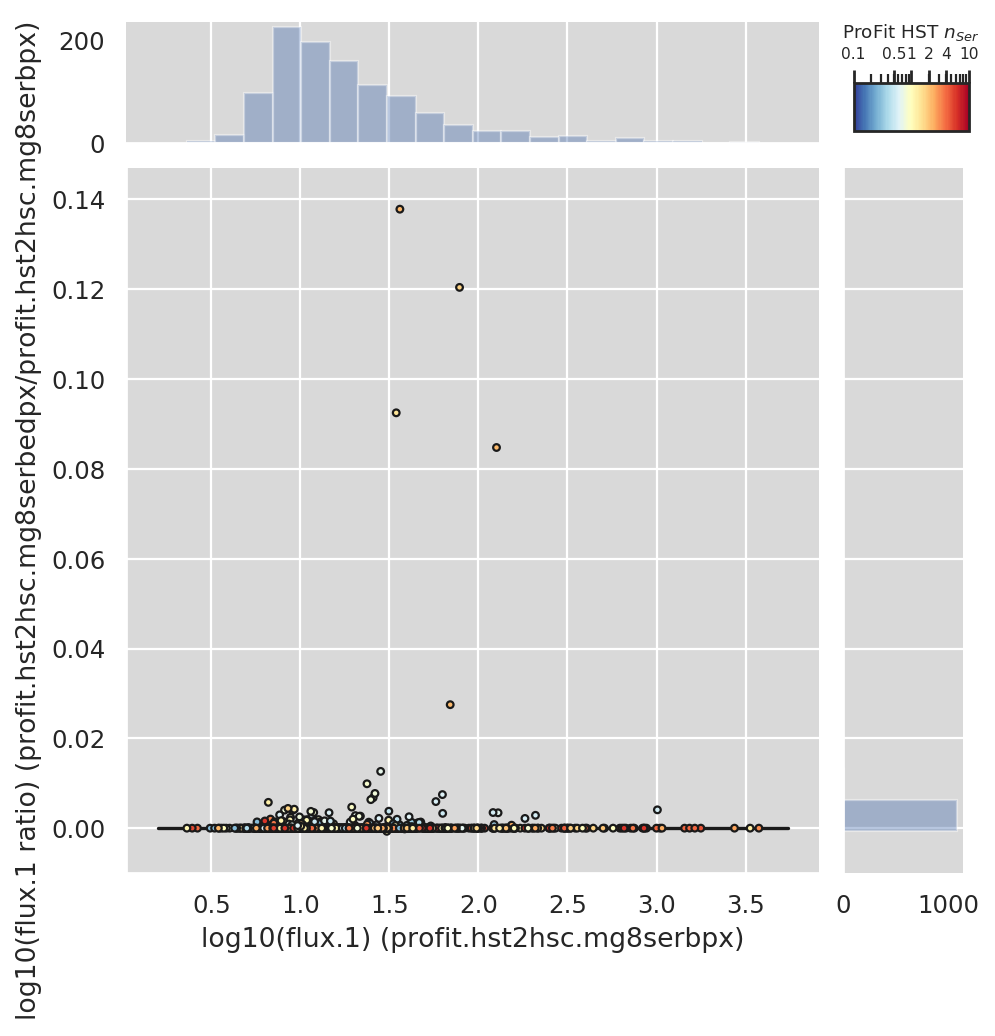

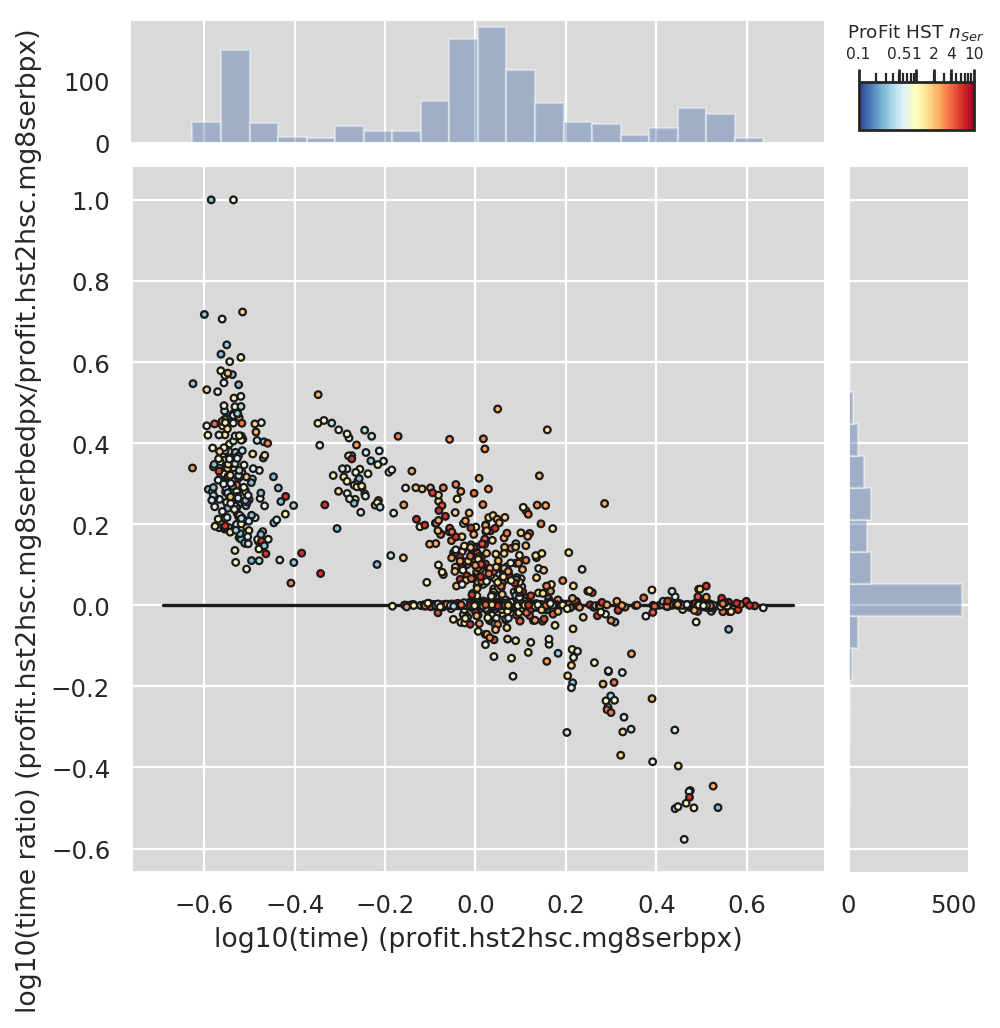

In [6]:
varnamesfit = ["flux.1", "time"]
plotjointsersic(tab, 'profit.hst2hsc.gausspx', 'profit.hst2hsc.mg8exppx', varnamesfit, plotratiosjoint=False)
plotjointsersic(tab, 'profit.hst2hsc.mg8exppx', 'profit.hst2hsc.mg8dev2px', varnamesfit, plotratiosjoint=False)
plotjointsersic(tab, 'profit.hst2hsc.mg8serbpx', 'profit.hst2hsc.mg8serbedpx', varnamesfit, plotratiosjoint=False)

### Cross-model initialization

There seems to be enough of a correlation between the sizes/fluxes (or surface brightness) that one could fit a polynomial and sample a few points along it as initial guesses. This should be strictly better than the current behaviour of inheriting the values directly, which is really just starting from (0,0) on this plot.

Also, this version sets explicit axis limits to zoom in better. TODO: Fix this in the plotting code directly.

2.4250e+01, 5.2205e+00, -3.4183e+00, 1.4000e+00, -1.7286e-02
-2.1874e+03, 6.2033e+02, -6.5462e+01, 4.0722e+00, -5.5988e-02


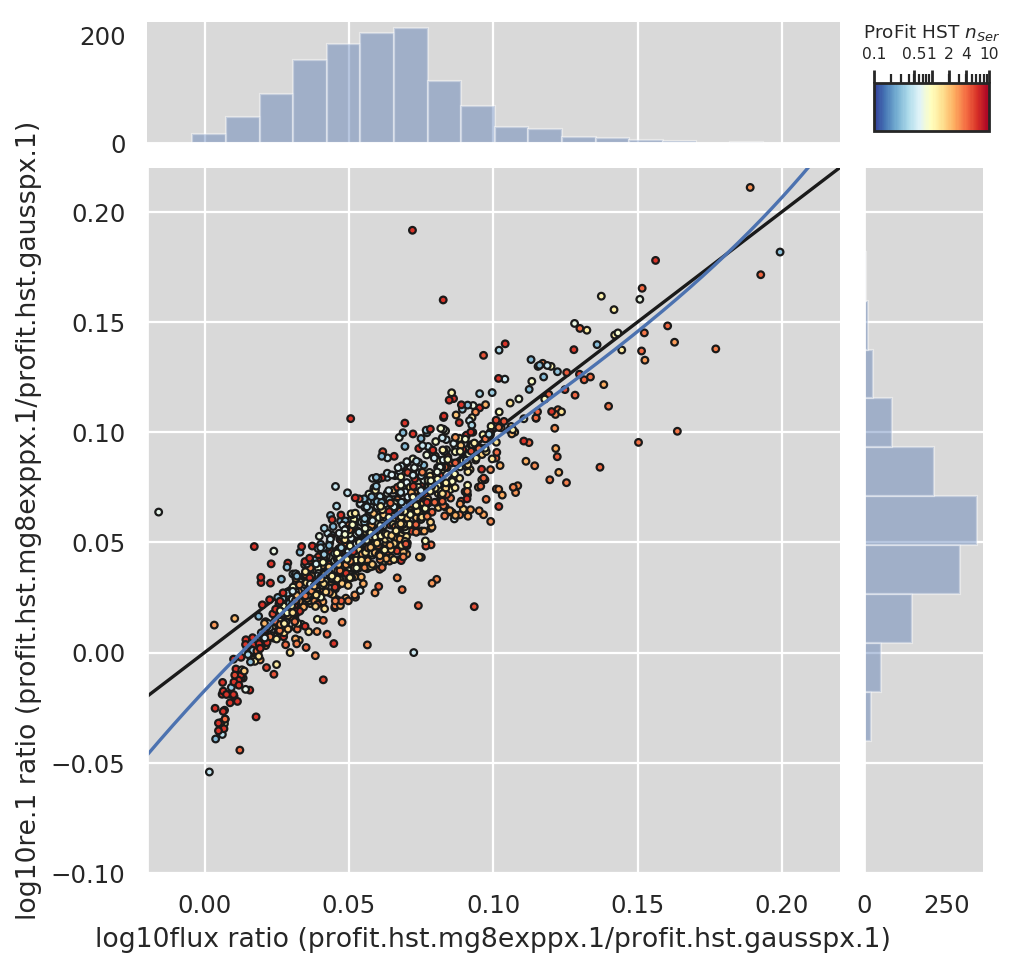

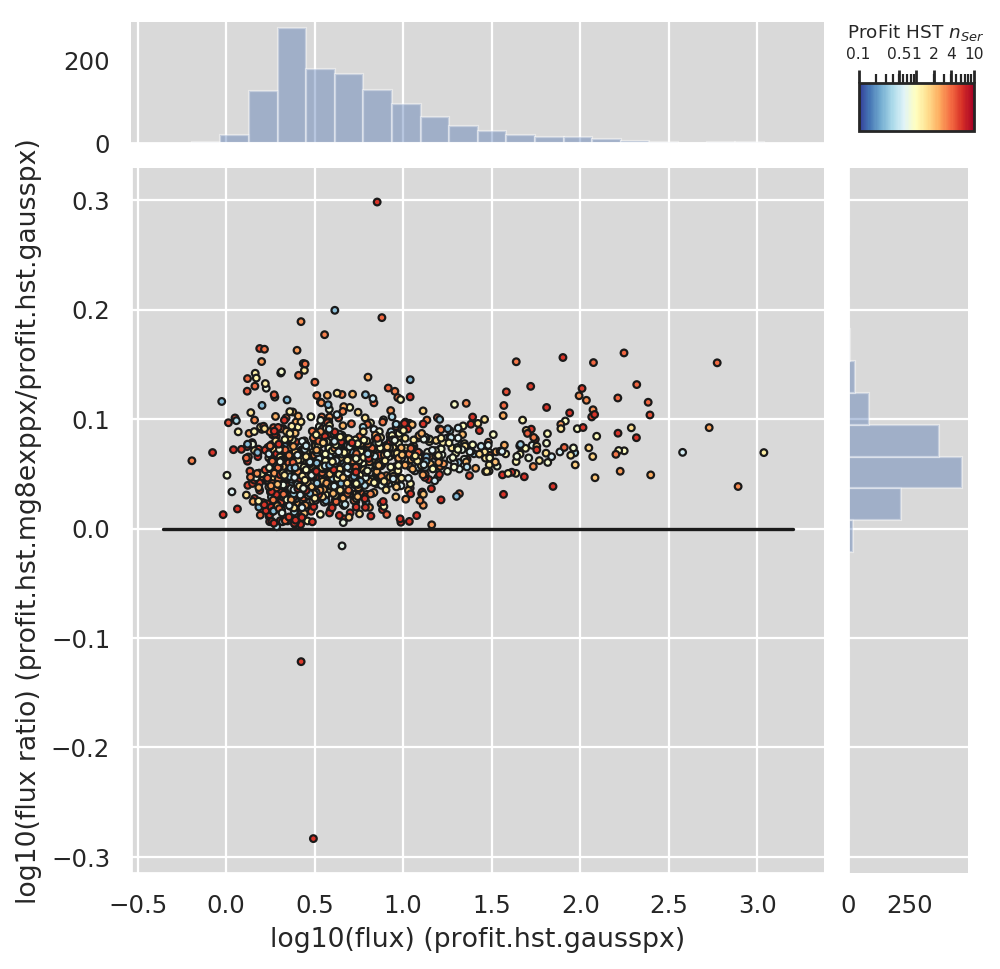

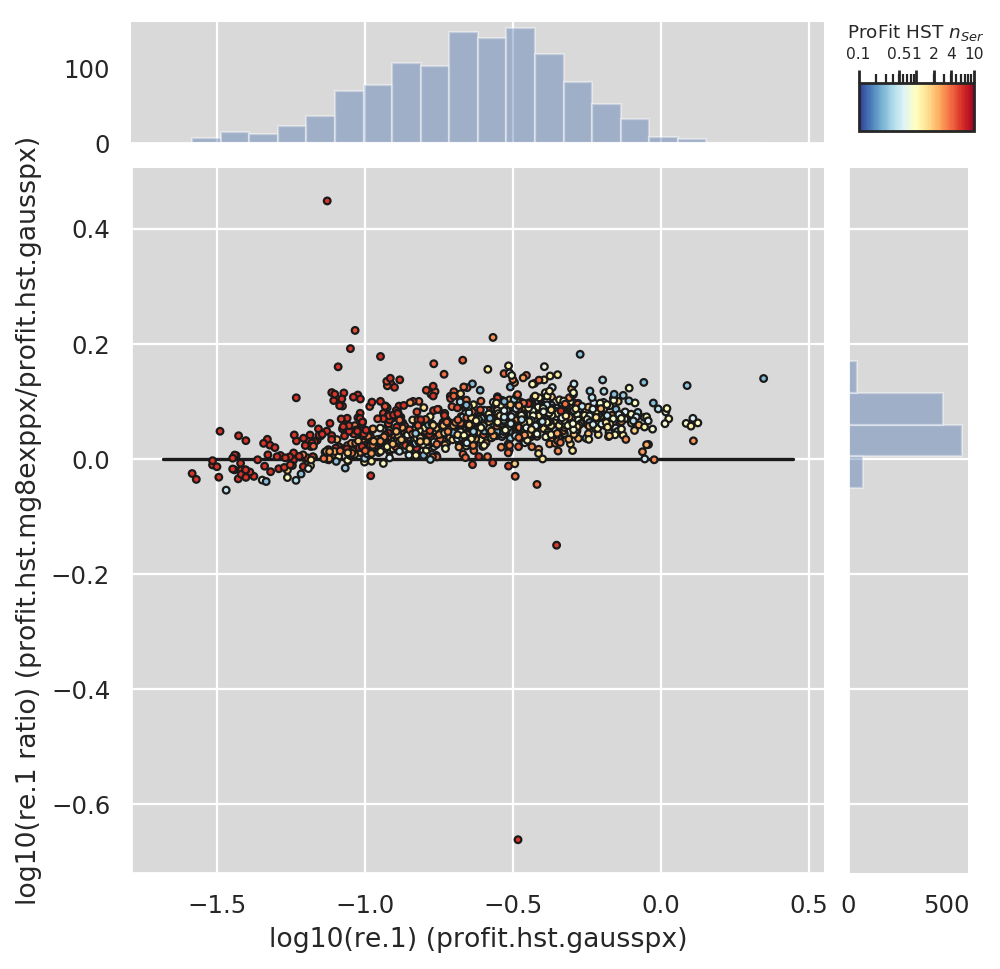

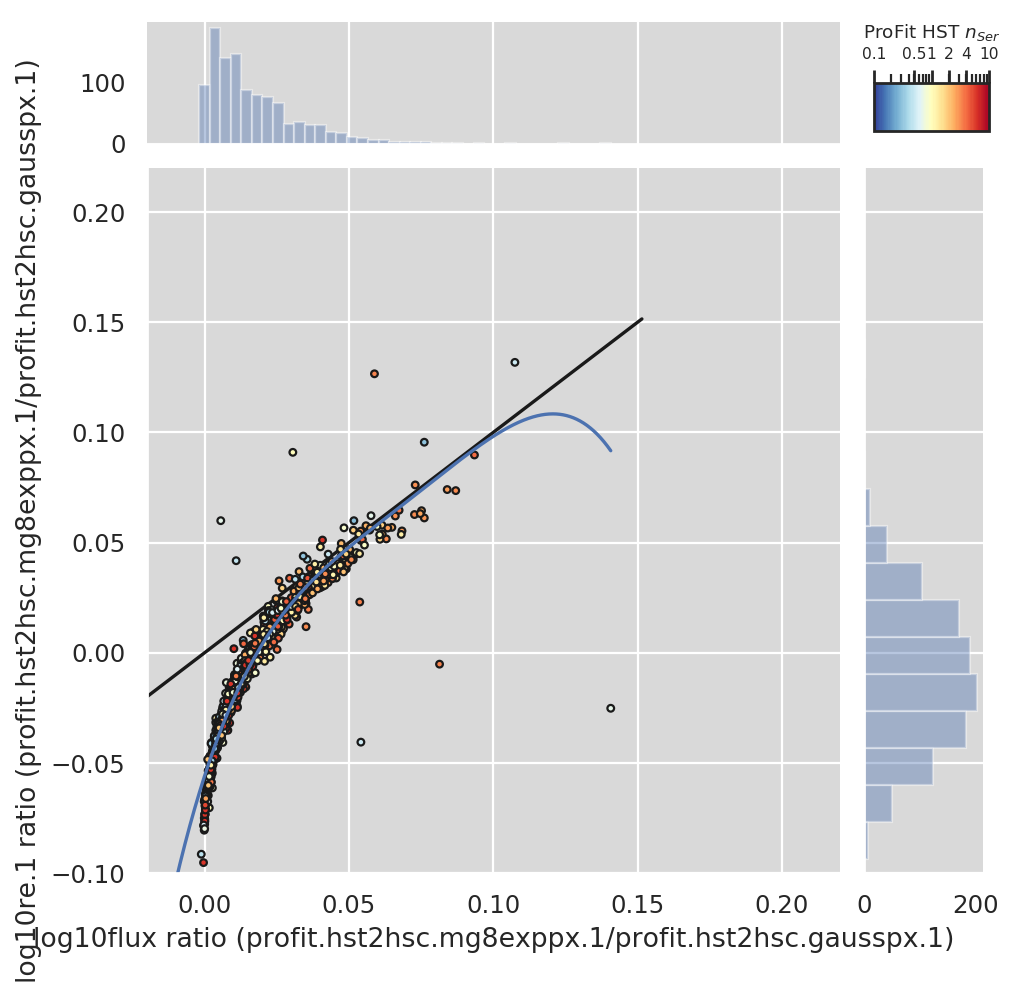

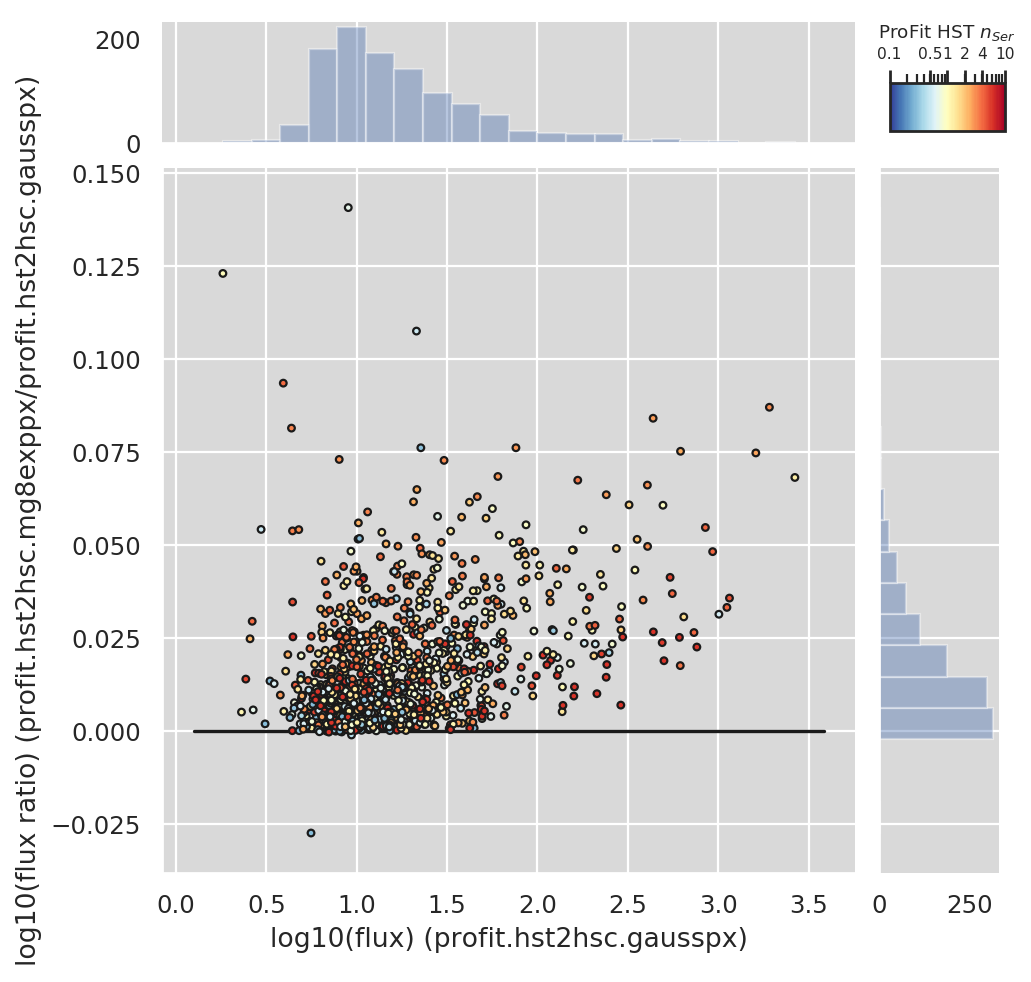

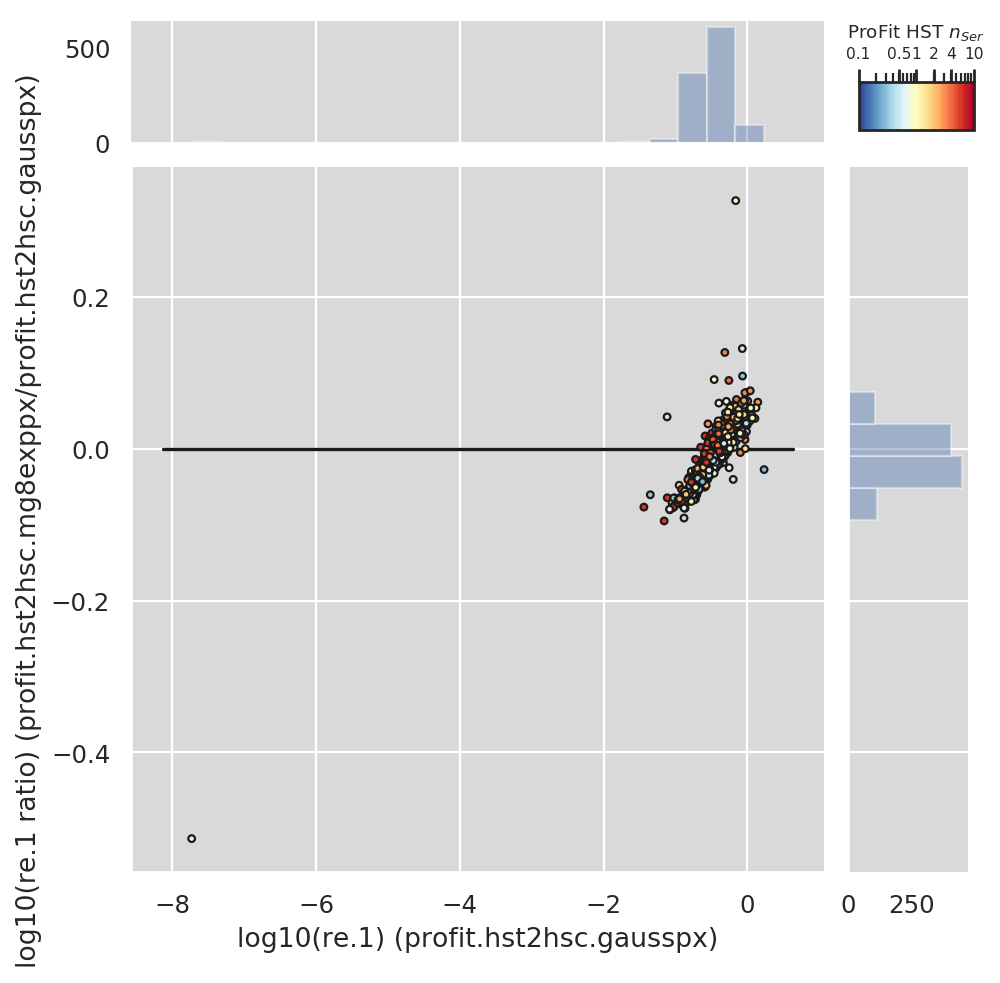

In [7]:
for src in ['hst', 'hst2hsc']:
    joints = plotjointsersic(tab, 'profit.' + src + '.gausspx', 'profit.' + src + '.mg8exppx', varnames, plotratiosjoint=True, postfixx='1', postfixy='1')
    plotratio = joints[1][0]
    plotratio.ax_joint.set_xlim((-0.02, 0.22))
    plotratio.ax_joint.set_ylim((-0.1, 0.22))
    pointsx = plotratio.x
    pointsy = plotratio.y
    coeffs = np.polyfit(pointsx, pointsy, 4)
    x = np.linspace(np.min(pointsx), np.max(pointsx), 1000)
    y = np.polyval(coeffs, x)
    plotratio.ax_joint.plot(x, y)
    print(', '.join(['{:.4e}'.format(x) for x in coeffs]))